# <center>Open Source Computer Vision-based Layer-wise 3D Printing Analysis</center>
<center><i>Aliaksei L. Petsiuk and Joshua M. Pearce | Michigan Technological University</i></center>

***

# <center>Image Processing Cycle</center>

![](img/algorithm_pipeline.jpg)

The image processing pipeline for a single layer could be divided into three branches:
1. Side view height validation
* Global trajectory correction
* Local texture analysis

Starting with the side-view height validation, the algorithm analyzes the virtual top view for global trajectory matching and local texture examination. This allows taking into account both global and local parameters of printing processes.

### <center><a id =0>Notebook contents</a></center>

1. [Import modules](#100)
* [Load input data](#200)
* [Parse source G-Code](#300)
* [Side view height validation](#400)
* [Global trajectory correction](#500)
* [Local texture analysis](#600)

# <a id =100>Import Modules</a>
[Back to contents](#0)

In [69]:
import numpy as np
import numpy.linalg as la

#--- for data visualization
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from mpl_toolkits import mplot3d
%matplotlib inline

#--- for image processing
import cv2
import scipy
from scipy import ndimage
import skimage
from skimage import filters, data, segmentation, color
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage import graph

#--- for stl processing
import meshcut
import stl #stl
from stl import mesh

#--- for gcode parser
from pygcode import *
from pygcode import Line
from pygcode import Machine, GCodeRapidMove

#--- for texture segmentation
from sklearn.mixture import GaussianMixture

#--- for multitemplate matching
import mtm
from mtm import matchTemplates

#--- for agglomerative clustering
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

#--- for convex hull of failures
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# <a id =200>Load Input Data</a>
[Back to contents](#0)

In [70]:
# Intrinsic camera parameters (obtained on the calibration stage)
# Source images have already been undistorted

camera_intrinsic_K = np.array(
                         [[1552.3, 0,      650.1],
                         [0,       1564.8, 486.2],
                         [0,       0,      1]], dtype = "float")
print("Camera Intrinsic Parameters :\n {}".format(camera_intrinsic_K))

Camera Intrinsic Parameters :
 [[1.5523e+03 0.0000e+00 6.5010e+02]
 [0.0000e+00 1.5648e+03 4.8620e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [71]:
# Image count starts from Layer 2, where Layer 1 - is an empty layer
# G-Code starts with Layer 0
# Therefore, we use LAYER_NUMBER variable for image processing,
# and (LAYER_NUMBER-2) for G-Code processing

LAYER_NUMBER = 9 # Layer number displayed on captured image
LAYER_THICKNESS = 0.4 # mm

z_level = LAYER_THICKNESS*(LAYER_NUMBER-2)

if(LAYER_NUMBER<10):
    # src = cv2.imread('dataset/rect_full/rect_L0%d.jpg' %LAYER_NUMBER, 0)
    src = cv2.imread('/home/joseph/Documents/GitHub/3D-Printer-Failure-Analysis/Computer-Vision-Models/Top-View-Model/Test-Images/printed_fox.jpg')
else:
    src = cv2.imread('dataset/rect_full/rect_L%d.jpg' %LAYER_NUMBER, 0)
    
img = src.copy()

print("Layer number displayed on captured image: LAYER_NUMBER = {}".format(LAYER_NUMBER))
print("Layer number saved in the G-Code file: LAYER_NUMBER-2 = {}".format(LAYER_NUMBER-2))
print("Height of the printed part: Z-level = LAYER_THICKNESS*(LAYER_NUMBER-2) = {:2f} mm".format(z_level))

Layer number displayed on captured image: LAYER_NUMBER = 9
Layer number saved in the G-Code file: LAYER_NUMBER-2 = 7
Height of the printed part: Z-level = LAYER_THICKNESS*(LAYER_NUMBER-2) = 2.800000 mm


In [72]:
# Image Projection: find cam transform based on 4 visual markers
# Manual calibration performed at the initial stage

#2D image points, [pixels]
image_points = np.array([
                            (391, 221),
                            (788, 77),
                            (1031, 368),
                            (569, 562),
                        ], dtype="double")
 
# 3D model points, [mm]
model_points = np.array([
                            (-44.0, -44.0, 0.0),
                            (-44.0, 44.0, 0.0),
                            (44.0, 44.0, 0.0),
                            (44.0, -44.0, 0.0)
                            ])

dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points,\
                                            camera_intrinsic_K, dist_coeffs,flags=cv2.SOLVEPNP_ITERATIVE)

print("Rotation Vector:\n {}".format(rotation_vector))
print("\nTranslation Vector:\n {}".format(translation_vector))

Rotation Vector:
 [[ 2.19859045]
 [ 1.36739407]
 [-0.5076201 ]]

Translation Vector:
 [[  7.90933162]
 [-35.74020151]
 [286.32063848]]


In [73]:
# Extrinsic camera parameters

C = np.zeros((4,4), dtype=float)
C[0:3,0:3] = cv2.Rodrigues(rotation_vector)[0]
C[0:3,3] = translation_vector.T
C[3,3] = 1

print("Camera position relative to printing bed")
print("C = \n{}".format(np.round(C,3)))

Camera position relative to printing bed
C = 
[[ 4.27000e-01  9.03000e-01 -5.10000e-02  7.90900e+00]
 [ 7.17000e-01 -3.72000e-01 -5.89000e-01 -3.57400e+01]
 [-5.51000e-01  2.15000e-01 -8.07000e-01  2.86321e+02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]


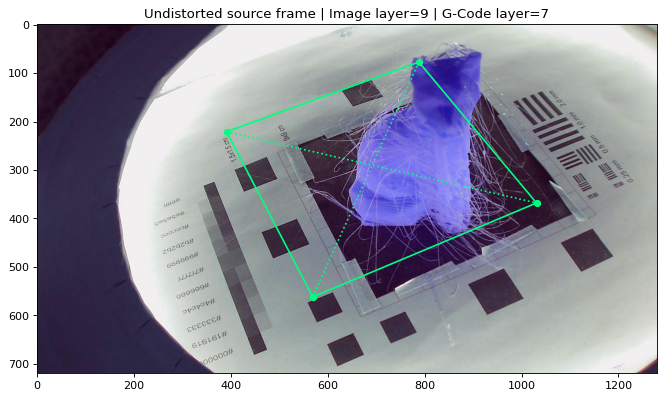

In [74]:
# Plot figure to see how well the reference anchor points were specified

fig = plt.figure(figsize=(10,6), dpi=80)
plt.imshow(img, cmap='gray')

plt.scatter(391,221,c='springgreen',s=30)
plt.scatter(788,77,c='springgreen',s=30)
plt.scatter(1031,368,c='springgreen',s=30)
plt.scatter(569,562,c='springgreen',s=30)

plt.plot([391,788],[221,77],c='springgreen')
plt.plot([788,1031],[77,368],c='springgreen')
plt.plot([1031,569],[368,562],c='springgreen')
plt.plot([569,391],[562,221],c='springgreen')

plt.plot([391,1031],[221,368],c='springgreen',linestyle=':')
plt.plot([788,569],[77,562],c='springgreen',linestyle=':')
plt.title("Undistorted source frame | Image layer={} | G-Code layer={}".format(LAYER_NUMBER,LAYER_NUMBER-2))
plt.show()

In [75]:
# Compensate object rotation 
# (in case of the STL orientation in slicer does not match the G-Code orientation)

otheta_x = 0.0 # degrees
otheta_y = 0.0 # degrees
otheta_z = 169.0 # degrees

# X and Y shifts are functions of layer number, where the 
# coefficients were calibrated experimantally during the first setup
ot_x = LAYER_NUMBER * 3/172 - 617/215
ot_y = LAYER_NUMBER * (-1/325) + 42/13
ot_z = 0.0

oRx = np.array([[1,0,0],[0,np.cos(otheta_x*np.pi/180),-np.sin(otheta_x*np.pi/180)],\
               [0,np.sin(otheta_x*np.pi/180),np.cos(otheta_x*np.pi/180)]]) # rotation around x
oRy = np.array([[np.cos(otheta_y*np.pi/180),0,np.sin(otheta_y*np.pi/180)],[0,1,0],\
               [-np.sin(otheta_y*np.pi/180),0,np.cos(otheta_y*np.pi/180)]]) # rotation around x
oRz = np.array([[np.cos(otheta_z*np.pi/180),-np.sin(otheta_z*np.pi/180),0],\
               [np.sin(otheta_z*np.pi/180),np.cos(otheta_z*np.pi/180),0],[0,0,1]]) # rotation around x

oR = np.dot(np.dot(oRx,oRy),oRz)
ot = np.array([ot_x,ot_y,ot_z])

#print('oRx = \n{}\n'.format(oRx))
#print('oRy = \n{}\n'.format(oRy))
#print('oRz = \n{}\n'.format(oRz))
#print('\noR = \n{}\n'.format(oR))

#print('\not = \n{}\n'.format(ot.T))

H = np.zeros((4,4), dtype=float)
H[0:3,0:3] = oR
H[0:3,3] = ot.T
H[3,3] = 1

print("Printing object position relative to the build plate origin")
print('H = \n{}\n'.format(H))

Printing object position relative to the build plate origin
H = 
[[-0.98162718 -0.190809    0.         -2.7127907 ]
 [ 0.190809   -0.98162718  0.          3.20307692]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]



# <a id =300>Parse source G-Code</a>
[Back to contents](#0)

In [80]:
# Various slicer programs provide different G-Code formats
# At this moment, the developed algorithm works only with G-Code generated by 
# "MatterControl" software (https://www.matterhackers.com/store/l/mattercontrol/sk/MKZGTDW6)

# Each G-Code category is assigned a specific number from 1 to 5:

# TYPE:WALL-OUTER          -- 1
# TYPE:WALL-INNER          -- 2
# TYPE:FILL                -- 3
# TYPE:SUPPORT             -- 4
# TYPE:SUPPORT-INTERFACE   -- 5


word_bank  = [] # e.g. "G1", "X15.03", etc.
layer_bank = [] # layer number: 0,1,2,...,N
type_bank  = [] # gcode type: 1,2,...,5.
line_bank  = [] # e.g. "G1 X0.01 Y0 Z0.4 F3000 ;comments"

parsed_Num_of_layers = 0
gcode_type = 0

with open('/home/joseph/Documents/GitHub/3D-Printer-Failure-Analysis/Computer-Vision-Models/Top-View-Model/Test-Gcode/70mm_low_poly_fox_MatterControl.gcode', 'r') as fh:
    for line_text in fh.readlines():
        line = Line(line_text) # all lines in file
        # print(line)
        w = line.block.words # splits blocks into XYZEF, omits comments
        # print(w)
        if(np.shape(w)[0] == 0): # if line is empty, i.e. comment line -> then skip it
            pass
        else:
            word_bank.append(w) # <Word: G01>, <Word: X15.03>, <Word: Y9.56>, <Word: Z0.269>, ...
            # print(word_bank) # does not process comments
            layer_bank.append(parsed_Num_of_layers)
            type_bank.append(gcode_type)
            line_bank.append(line_text)

        if line.comment:
            #print(line.comment)
            if (line.comment.text[0:6] == "LAYER:"):
                parsed_Num_of_layers = parsed_Num_of_layers + 1
                gcode_type = 0
            if line.comment:
                if (line.comment.text[0:15] == "TYPE:WALL-OUTER"):
                    #print("TYPE:WALL-OUTER")
                    gcode_type = 1
                if (line.comment.text[0:15] == "TYPE:WALL-INNER"):
                    #print("TYPE:WALL-INNER")
                    gcode_type = 2
                if (line.comment.text[0:9] == "TYPE:FILL"):
                    #print("TYPE:FILL")
                    gcode_type = 3
                if (line.comment.text[0:12] == "TYPE:SUPPORT"):
                    #print("TYPE:SUPPORT")
                    gcode_type = 4
                if (line.comment.text[0:22] == "TYPE:SUPPORT-INTERFACE"):
                    #print("TYPE:SUPPORT-INTERFACE")
                    gcode_type = 5
                
print("Number of parsed layers = {}".format(parsed_Num_of_layers))

Number of parsed layers = 175


539
539


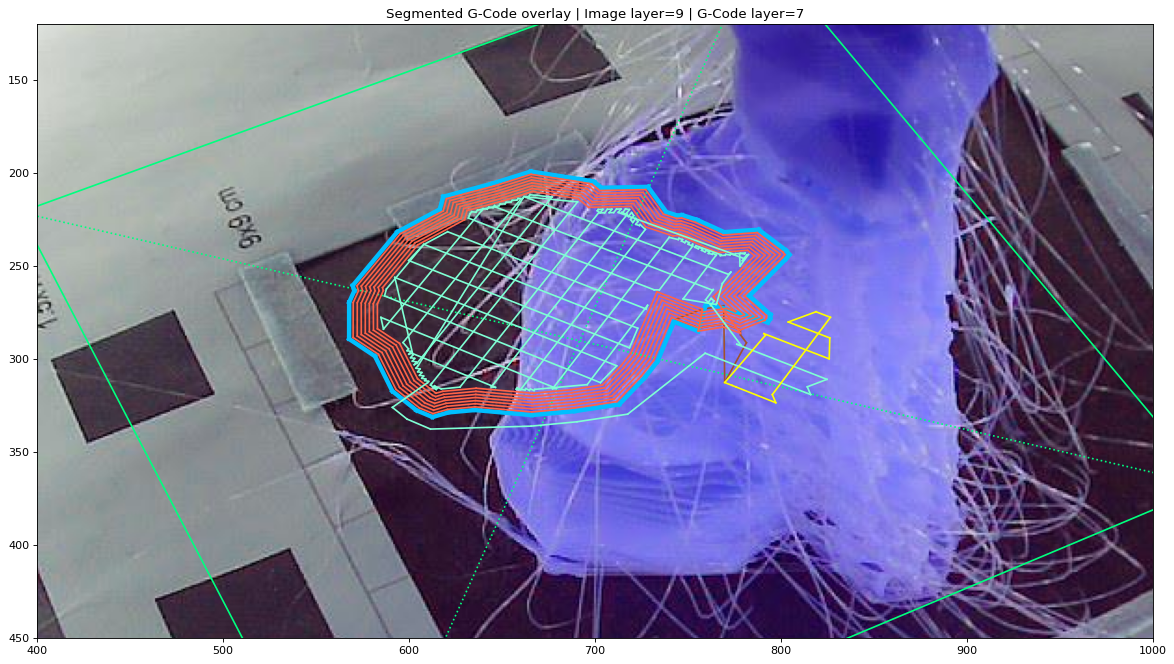

In [81]:
# Project the G-Code to the source image to obtain the reference contour
# for vertical level validation and global contour matching

fig = plt.figure(figsize=(18,14), dpi=80)
plt.imshow(img,cmap='gray')

plt.scatter(391,221,c='springgreen',s=30)
plt.scatter(788,77,c='springgreen',s=30)
plt.scatter(1031,368,c='springgreen',s=30)
plt.scatter(569,562,c='springgreen',s=30)

plt.plot([391,788],[221,77],c='springgreen')
plt.plot([788,1031],[77,368],c='springgreen')
plt.plot([1031,569],[368,562],c='springgreen')
plt.plot([569,391],[562,221],c='springgreen')

plt.plot([391,1031],[221,368],c='springgreen',linestyle=':')
plt.plot([788,569],[77,562],c='springgreen',linestyle=':')


# for k in [6,8,70]: # for k in range(2,24,2) # draw for multiple layers

#Go through each layer 
for k in [LAYER_NUMBER-1]: # layers
    command_bank = []
    line_command_bank = []
    gcode_line_number = 0
    
    # create additional arrays for gcode segmentation
    X_active_bank = []
    Y_active_bank = []
    Z_active_bank = []
    G_active_bank = []
    E_active_bank = []
    F_active_bank = []

    idx = []
    
    X_active_default = []; X_active_wall_outer = []; X_active_wall_inner = []
    Y_active_default = []; Y_active_wall_outer = []; Y_active_wall_inner = []
    Z_active_default = []; Z_active_wall_outer = []; Z_active_wall_inner = []
    G_active_default = []; G_active_wall_outer = []; G_active_wall_inner = []
    E_active_default = []; E_active_wall_outer = []; E_active_wall_inner = []
    F_active_default = []; F_active_wall_outer = []; F_active_wall_inner = []
    
    # auxiliary layer duplicates shifted by +1 and -1 layer height
    # for additional visual inspection that can be done by the user

    ## May not be required
    Z_active_wall_inner_top_aux = []; Z_active_wall_inner_bot_aux = []

    X_active_fill = []; X_active_support = []; X_active_support_interface = []
    Y_active_fill = []; Y_active_support = []; Y_active_support_interface = []
    Z_active_fill = []; Z_active_support = []; Z_active_support_interface = []
    G_active_fill = []; G_active_support = []; G_active_support_interface = []
    E_active_fill = []; E_active_support = []; E_active_support_interface = []
    F_active_fill = []; F_active_support = []; F_active_support_interface = []
    
    for i in range(len(layer_bank)): # for each line in file
        if (layer_bank[i] == k):
            #idx = index value of list
            idx.append(i)
            
            #Add command for this line to bank
            line_command_bank.append(line_bank[i])

            # line_command_bank = all gcode for the specific layer without comments
            for j in range(len(word_bank[i])):
                command_bank.append(str(word_bank[i][j]))
                if (str(word_bank[i][j])[:1] == 'G'):
                    G_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'X'):
                    X_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'Y'):
                    Y_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'Z'):
                    Z_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'E'):
                    E_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'F'):
                    F_active_bank.append(float(str(word_bank[i][j])[1:]))
    print(len(X_active_bank))
    print(len(Z_active_bank))
    for m in range(len(X_active_bank)):
        if(type_bank[np.min(idx)+m] == 0):
            X_active_default.append(X_active_bank[m])
            Y_active_default.append(Y_active_bank[m])
            Z_active_default.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 1):
            X_active_wall_outer.append(X_active_bank[m])
            Y_active_wall_outer.append(Y_active_bank[m])
            Z_active_wall_outer.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 2):
            X_active_wall_inner.append(X_active_bank[m])
            Y_active_wall_inner.append(Y_active_bank[m])
            Z_active_wall_inner.append(Z_active_bank[m])
            #--------------------
            Z_active_wall_inner_top_aux.append(Z_active_bank[m]+LAYER_THICKNESS*2)
            Z_active_wall_inner_bot_aux.append(Z_active_bank[m]-LAYER_THICKNESS*2)
            #--------------------
        if(type_bank[np.min(idx)+m] == 3):
            X_active_fill.append(X_active_bank[m])
            Y_active_fill.append(Y_active_bank[m])
            Z_active_fill.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 4):
            X_active_support.append(X_active_bank[m])
            Y_active_support.append(Y_active_bank[m])
            Z_active_support.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 5):
            X_active_support_interface.append(X_active_bank[m])
            Y_active_support_interface.append(Y_active_bank[m])
            Z_active_support_interface.append(Z_active_bank[m])

            
    G_default = np.zeros((np.shape(X_active_default)[0],4),dtype=np.float32)
    G_wall_outer = np.zeros((np.shape(X_active_wall_outer)[0],4),dtype=np.float32)
    G_wall_inner = np.zeros((np.shape(X_active_wall_inner)[0],4),dtype=np.float32)
    G_fill = np.zeros((np.shape(X_active_fill)[0],4),dtype=np.float32)
    G_support = np.zeros((np.shape(X_active_support)[0],4),dtype=np.float32)
    G_support_interface = np.zeros((np.shape(X_active_support_interface)[0],4),dtype=np.float32)
    
    #--------------------
    G_wall_inner_top_aux = np.zeros((np.shape(X_active_wall_inner)[0],4),dtype=np.float32)
    G_wall_inner_bot_aux = np.zeros((np.shape(X_active_wall_inner)[0],4),dtype=np.float32)
    #--------------------

    G_default[:,0] = X_active_default
    G_default[:,1] = Y_active_default
    G_default[:,2] = Z_active_default
    G_default[:,3] = np.ones((1,np.shape(X_active_default)[0]),dtype=np.float32)

    G_wall_outer[:,0] = X_active_wall_outer
    G_wall_outer[:,1] = Y_active_wall_outer
    G_wall_outer[:,2] = Z_active_wall_outer
    G_wall_outer[:,3] = np.ones((1,np.shape(X_active_wall_outer)[0]),dtype=np.float32)

    G_wall_inner[:,0] = X_active_wall_inner
    G_wall_inner[:,1] = Y_active_wall_inner
    G_wall_inner[:,2] = Z_active_wall_inner
    G_wall_inner[:,3] = np.ones((1,np.shape(X_active_wall_inner)[0]),dtype=np.float32)
    
    #-----------------------
    
    G_wall_inner_top_aux[:,0] = X_active_wall_inner
    G_wall_inner_top_aux[:,1] = Y_active_wall_inner
    G_wall_inner_top_aux[:,2] = Z_active_wall_inner_top_aux
    G_wall_inner_top_aux[:,3] = np.ones((1,np.shape(X_active_wall_inner)[0]),dtype=np.float32)
    
    G_wall_inner_bot_aux[:,0] = X_active_wall_inner
    G_wall_inner_bot_aux[:,1] = Y_active_wall_inner
    G_wall_inner_bot_aux[:,2] = Z_active_wall_inner_bot_aux
    G_wall_inner_bot_aux[:,3] = np.ones((1,np.shape(X_active_wall_inner)[0]),dtype=np.float32)
    
    #-----------------------

    G_fill[:,0] = X_active_fill
    G_fill[:,1] = Y_active_fill
    G_fill[:,2] = Z_active_fill
    G_fill[:,3] = np.ones((1,np.shape(X_active_fill)[0]),dtype=np.float32)

    G_support[:,0] = X_active_support
    G_support[:,1] = Y_active_support
    G_support[:,2] = Z_active_support
    G_support[:,3] = np.ones((1,np.shape(X_active_support)[0]),dtype=np.float32)

    G_support_interface[:,0] = X_active_support_interface
    G_support_interface[:,1] = Y_active_support_interface
    G_support_interface[:,2] = Z_active_support_interface
    G_support_interface[:,3] = np.ones((1,np.shape(X_active_support_interface)[0]),dtype=np.float32)
    
    tG_default = np.zeros((np.shape(G_default)[0],4), dtype=np.float32)
    tG_wall_outer = np.zeros((np.shape(G_wall_outer)[0],4), dtype=np.float32)
    tG_wall_inner = np.zeros((np.shape(G_wall_inner)[0],4), dtype=np.float32)
    tG_fill = np.zeros((np.shape(G_fill)[0],4), dtype=np.float32)
    tG_support = np.zeros((np.shape(G_support)[0],4), dtype=np.float32)
    tG_support_interface = np.zeros((np.shape(G_support_interface)[0],4), dtype=np.float32)
    #-----------------------
    tG_wall_inner_top_aux = np.zeros((np.shape(G_wall_inner_top_aux)[0],4), dtype=np.float32)
    tG_wall_inner_bot_aux = np.zeros((np.shape(G_wall_inner_bot_aux)[0],4), dtype=np.float32)
    
    for i in range(np.shape(G_default)[0]):
        tG_default[i] = np.dot(H,G_default[i])
    for i in range(np.shape(G_wall_outer)[0]):
        tG_wall_outer[i] = np.dot(H,G_wall_outer[i])
    for i in range(np.shape(G_wall_inner)[0]):
        tG_wall_inner[i] = np.dot(H,G_wall_inner[i])
    for i in range(np.shape(G_fill)[0]):
        tG_fill[i] = np.dot(H,G_fill[i])
    for i in range(np.shape(G_support)[0]):
        tG_support[i] = np.dot(H,G_support[i])
    for i in range(np.shape(G_support_interface)[0]):
        tG_support_interface[i] = np.dot(H,G_support_interface[i])
    #-----------------------
    for i in range(np.shape(G_wall_inner_top_aux)[0]):
        tG_wall_inner_top_aux[i] = np.dot(H,G_wall_inner_top_aux[i])
    for i in range(np.shape(G_wall_inner_bot_aux)[0]):
        tG_wall_inner_bot_aux[i] = np.dot(H,G_wall_inner_bot_aux[i])
        
        
    tGp_default = cv2.projectPoints(np.asarray(tG_default[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    tGp_wall_outer = cv2.projectPoints(np.asarray(tG_wall_outer[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    tGp_wall_inner = cv2.projectPoints(np.asarray(tG_wall_inner[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    tGp_fill = cv2.projectPoints(np.asarray(tG_fill[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)

    tGp_support = cv2.projectPoints(np.asarray(tG_support[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    #tGp_support_interface = cv2.projectPoints(np.asarray(tG_support_interface[:,0:3],dtype=float),\
                    #rotation_vector,translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    #-----------------------
    tGp_wall_inner_top_aux = cv2.projectPoints(np.asarray(tG_wall_inner_top_aux[:,0:3],dtype=float),\
                    rotation_vector,translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    tGp_wall_inner_bot_aux = cv2.projectPoints(np.asarray(tG_wall_inner_bot_aux[:,0:3],dtype=float),\
                    rotation_vector,translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
        
        
    for i in range(np.shape(tGp_default)[0]):
        plt.plot([tGp_default[i][0],tGp_default[i-1][0]],[tGp_default[i][1],tGp_default[i-1][1]],color='sienna')
    for i in range(np.shape(tGp_wall_outer)[0]):
        plt.plot([tGp_wall_outer[i][0],tGp_wall_outer[i-1][0]],\
             [tGp_wall_outer[i][1],tGp_wall_outer[i-1][1]],color='deepskyblue',linewidth=4)
    for i in range(np.shape(tGp_wall_inner)[0]):
        plt.plot([tGp_wall_inner[i][0],tGp_wall_inner[i-1][0]],\
                 [tGp_wall_inner[i][1],tGp_wall_inner[i-1][1]],color='tomato')
    for i in range(np.shape(tGp_fill)[0]):
        plt.plot([tGp_fill[i][0],tGp_fill[i-1][0]],[tGp_fill[i][1],tGp_fill[i-1][1]],color='aquamarine')
    for i in range(np.shape(tGp_support)[0]):
        plt.plot([tGp_support[i][0],tGp_support[i-1][0]],[tGp_support[i][1],tGp_support[i-1][1]],color='yellow')
    #-----------------------
    # uncomment to use the aux trajectories (+1, -1 layer height)
    '''for i in range(np.shape(tGp_wall_inner_top_aux)[0]):
        plt.plot([tGp_wall_inner_top_aux[i][0],tGp_wall_inner_top_aux[i-1][0]],\
                 [tGp_wall_inner_top_aux[i][1],tGp_wall_inner_top_aux[i-1][1]],color='pink')
    for i in range(np.shape(tGp_wall_inner_bot_aux)[0]):
        plt.plot([tGp_wall_inner_bot_aux[i][0],tGp_wall_inner_bot_aux[i-1][0]],\
                 [tGp_wall_inner_bot_aux[i][1],tGp_wall_inner_bot_aux[i-1][1]],color='hotpink')'''
plt.title("Segmented G-Code overlay | Image layer={} | G-Code layer={}".format(LAYER_NUMBER,LAYER_NUMBER-2))
plt.xlim(400,1000)
plt.ylim(450,120)
plt.show()

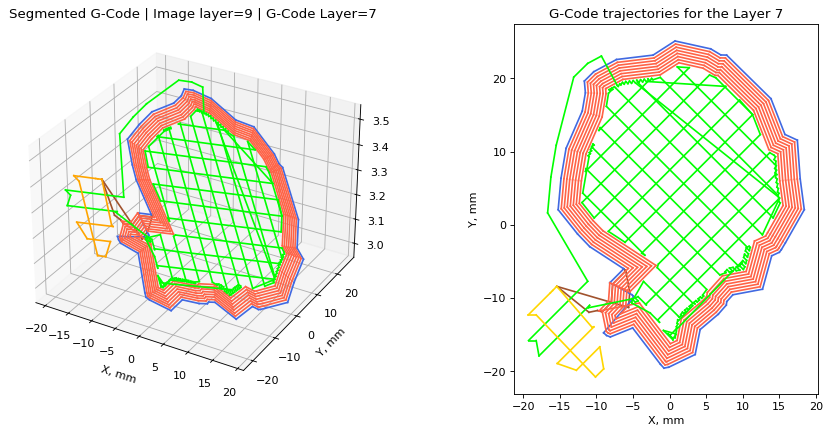

In [82]:
# Plot separate segmented G-Code trajectories for the single ayer

fig = plt.figure(figsize=(14,6), dpi=80)
ax = fig.add_subplot(121, projection='3d')
for i in range(len(X_active_default)):
    ax.plot([X_active_default[i],X_active_default[i-1]],
        [Y_active_default[i],Y_active_default[i-1]],
        [Z_active_default[i],Z_active_default[i-1]],color='sienna')

for i in range(len(X_active_wall_outer)):
    ax.plot([X_active_wall_outer[i],X_active_wall_outer[i-1]],
        [Y_active_wall_outer[i],Y_active_wall_outer[i-1]],
        [Z_active_wall_outer[i],Z_active_wall_outer[i-1]],color='royalblue')

for i in range(len(X_active_wall_inner)):
    ax.plot([X_active_wall_inner[i],X_active_wall_inner[i-1]],
        [Y_active_wall_inner[i],Y_active_wall_inner[i-1]],
        [Z_active_wall_inner[i],Z_active_wall_inner[i-1]],color='tomato')

for i in range(len(X_active_fill)):
    ax.plot([X_active_fill[i],X_active_fill[i-1]],
        [Y_active_fill[i],Y_active_fill[i-1]],
        [Z_active_fill[i],Z_active_fill[i-1]],color='lime')

for i in range(len(X_active_support)):
    ax.plot([X_active_support[i],X_active_support[i-1]],
        [Y_active_support[i],Y_active_support[i-1]],
        [Z_active_support[i],Z_active_support[i-1]],color='orange')

for i in range(len(X_active_support_interface)):
    ax.plot([X_active_support_interface[i],X_active_support_interface[i-1]],
        [Y_active_support_interface[i],Y_active_support_interface[i-1]],
        [Z_active_support_interface[i],Z_active_support_interface[i-1]],color='cyan')
ax.set_xlabel('X, mm')
ax.set_ylabel('Y, mm')
ax.set_title('Segmented G-Code | Image layer={} | G-Code Layer={}'.format(LAYER_NUMBER,LAYER_NUMBER-2))


ax = fig.add_subplot(122)
for i in range(len(X_active_default)):
    ax.plot([X_active_default[i],X_active_default[i-1]],
        [Y_active_default[i],Y_active_default[i-1]],color='sienna')

for i in range(len(X_active_wall_outer)):
    ax.plot([X_active_wall_outer[i],X_active_wall_outer[i-1]],
        [Y_active_wall_outer[i],Y_active_wall_outer[i-1]],color='royalblue')

for i in range(len(X_active_wall_inner)):
    ax.plot([X_active_wall_inner[i],X_active_wall_inner[i-1]],
        [Y_active_wall_inner[i],Y_active_wall_inner[i-1]],color='tomato')

for i in range(len(X_active_fill)):
    ax.plot([X_active_fill[i],X_active_fill[i-1]],
        [Y_active_fill[i],Y_active_fill[i-1]],color='lime')

for i in range(len(X_active_support)):
    ax.plot([X_active_support[i],X_active_support[i-1]],
        [Y_active_support[i],Y_active_support[i-1]],color='gold')

for i in range(len(X_active_support_interface)):
    ax.plot([X_active_support_interface[i],X_active_support_interface[i-1]],
        [Y_active_support_interface[i],Y_active_support_interface[i-1]],color='cyan')
ax.set_xlabel('X, mm')
ax.set_ylabel('Y, mm')
ax.set_title('G-Code trajectories for the Layer {}'.format(LAYER_NUMBER-2))
ax.grid(False)
ax.set_aspect(1)


plt.show()

# <a id =400>Side view height validation</a>
[Back to contents](#0)

In [ ]:
# Here we create two masks (outer and inner) from the gcode type:wall-inner
# then substact "inner" from outer" to get the gcode-precise outline

gcode_mask_outer = np.zeros((src.shape), dtype=np.uint8)
cv2.polylines(gcode_mask_outer,[np.asarray(tGp_wall_inner,dtype=int)],False,(200,200,200),5)

gcode_mask_inner = np.zeros((src.shape), dtype=np.uint8)
cv2.polylines(gcode_mask_inner,[np.asarray(tGp_wall_inner,dtype=int)],False,(200,200,200),4)

### creating additional contours for the layers before and after
gcode_mask_outer_top = np.zeros((src.shape), dtype=np.uint8)
gcode_mask_inner_top = np.zeros((src.shape), dtype=np.uint8)
cv2.polylines(gcode_mask_outer_top,[np.asarray(tGp_wall_inner_top_aux,dtype=int)],False,(200,200,200),5)
cv2.polylines(gcode_mask_inner_top,[np.asarray(tGp_wall_inner_top_aux,dtype=int)],False,(200,200,200),4)

gcode_mask_outer_bot = np.zeros((src.shape), dtype=np.uint8)
gcode_mask_inner_bot = np.zeros((src.shape), dtype=np.uint8)
cv2.polylines(gcode_mask_outer_bot,[np.asarray(tGp_wall_inner_bot_aux,dtype=int)],False,(200,200,200),5)
cv2.polylines(gcode_mask_inner_bot,[np.asarray(tGp_wall_inner_bot_aux,dtype=int)],False,(200,200,200),4)

print(np.shape(src))
print(np.shape(gcode_mask_outer))
print(np.shape(gcode_mask_inner))

(720, 1280)
(720, 1280)
(720, 1280)


In [ ]:
# Generating a precise 1px outline for the outer edge

final_mask = gcode_mask_outer*gcode_mask_inner
contours, hierarchy = cv2.findContours(final_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

final_mask_top = gcode_mask_outer_top*gcode_mask_inner_top
final_mask_bot = gcode_mask_outer_bot*gcode_mask_inner_bot
contours_top, hierarchy_top = cv2.findContours(final_mask_top, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_bot, hierarchy_bot = cv2.findContours(final_mask_bot, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
# Get the points from the detected opencv contours

# ------------------------------------------- Outer Shell
img = np.zeros((src.shape), np.uint8)

height = np.shape(final_mask)[0]
width = np.shape(final_mask)[1]

noOfCoordinates_t = 0
coordX_t = []
coordY_t = []
edgeMagnitude_t = []
edgeDerivativeX_t = []
edgeDerivativeY_t = []

shell = np.zeros((height,width,1), dtype=np.float32)
shell = np.squeeze(shell)

RSum = 0
CSum = 0

# draw contour 0
cv2.drawContours(img, contours, 0, (255,255,255), 1)

for i in range(0,width):
    for j in range(0,height):
        if (img[j][i] != 0):
            RSum = RSum+i
            CSum = CSum+j
            coordX_t.append(i)
            coordY_t.append(j)
            noOfCoordinates_t += 1
            shell[j][i]=1

center_gravity_x_outer = RSum/(noOfCoordinates_t+1e-6)
center_gravity_y_outer = CSum/(noOfCoordinates_t+1e-6)

outer_shell=np.vstack([(coordX_t),(coordY_t)])



# ------------------------- Inner Shell TOP (auxiliary contour to double check the max error gap)
img_top_aux = np.zeros((src.shape), np.uint8)

shell_top_aux = np.zeros((height,width,1), dtype=np.float32)
shell_top_aux = np.squeeze(shell_top_aux)

cv2.drawContours(img_top_aux, contours_top, 0, (255,255,255), 1)

coordX_t = []
coordY_t = []

for i in range(0,width):
    for j in range(0,height):
        if (img_top_aux[j][i] != 0):
            coordX_t.append(i)
            coordY_t.append(j)
            shell_top_aux[j][i]=1

outer_shell_top_aux = np.vstack([(coordX_t),(coordY_t)])


# ------------------------- Inner Shell BOTTOM  (auxiliary contour to double check the max error gap)
img_bot_aux = np.zeros((src.shape), np.uint8)

shell_bot_aux = np.zeros((height,width,1), dtype=np.float32)
shell_bot_aux = np.squeeze(shell_bot_aux)

cv2.drawContours(img_bot_aux, contours_bot, 0, (255,255,255), 1)

coordX_t = []
coordY_t = []

for i in range(0,width):
    for j in range(0,height):
        if (img_bot_aux[j][i] != 0):
            coordX_t.append(i)
            coordY_t.append(j)
            shell_bot_aux[j][i]=1

outer_shell_bot_aux = np.vstack([(coordX_t),(coordY_t)])



# ------------------------------------------- Inner Shell
img = np.zeros((src.shape), np.uint8)

height = np.shape(final_mask)[0]
width = np.shape(final_mask)[1]

noOfCoordinates_t = 0
coordX_t = []
coordY_t = []
edgeMagnitude_t = []
edgeDerivativeX_t = []
edgeDerivativeY_t = []

shell = np.zeros((height,width,1), dtype=np.float32)
shell = np.squeeze(shell)

RSum = 0
CSum = 0

# draw contour 1
if(np.shape(contours)[0]==2):
    cv2.drawContours(img, contours, 1, (255,255,255), 1)
elif(np.shape(contours)[0]==3):
    cv2.drawContours(img, contours, 2, (255,255,255), 1)

for i in range(0,height):
    for j in range(0,width):
        if (img[i][j] != 0):
            RSum = RSum+j
            CSum = CSum+i
            coordX_t.append(j)
            coordY_t.append(i)
            noOfCoordinates_t += 1
            shell[i][j]=1

center_gravity_x_inner = RSum/(noOfCoordinates_t+1e-6)
center_gravity_y_inner = CSum/(noOfCoordinates_t+1e-6)

inner_shell=np.vstack([(coordX_t),(coordY_t)])

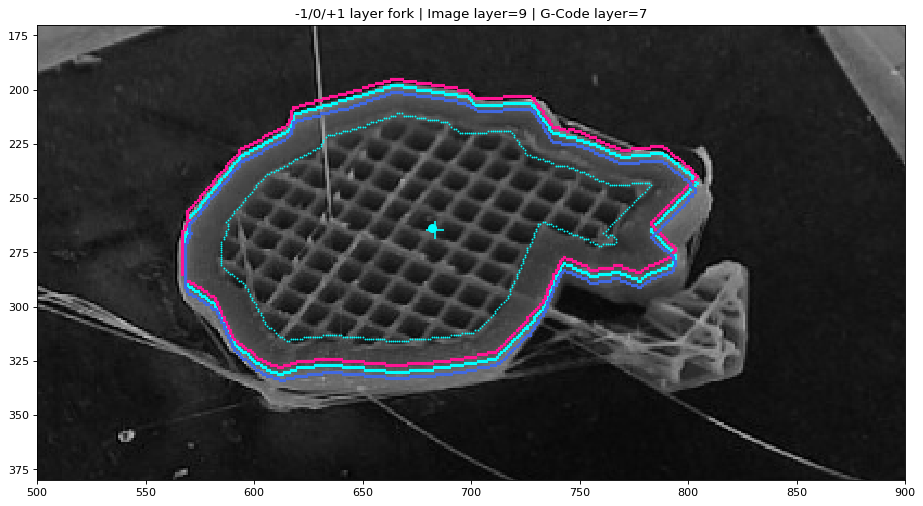

In [ ]:
# Plot detected layer outline plus two auxiliary (+1 up and -1 down) layer contours

fig = plt.figure(figsize=(14,14), dpi=80)
plt.imshow(src,cmap='gray')
plt.scatter(outer_shell[0],outer_shell[1],s=2,color='cyan',marker='s')
plt.scatter(center_gravity_x_outer,center_gravity_y_outer,s=250,marker='+',color='cyan')

plt.scatter(outer_shell_top_aux[0],outer_shell_top_aux[1],s=1,color='deeppink',marker='s') # +1 layer
plt.scatter(outer_shell_bot_aux[0],outer_shell_bot_aux[1],s=1,color='royalblue',marker='s') # -1 layer

plt.scatter(inner_shell[0],inner_shell[1],s=2,color='cyan',marker='.')
plt.scatter(center_gravity_x_inner,center_gravity_y_inner,s=50,marker='o',color='cyan')
plt.xlim(500,900)
plt.ylim(380,170)
plt.title("-1/0/+1 layer fork | Image layer={} | G-Code layer={}".format(LAYER_NUMBER,LAYER_NUMBER-2))
plt.show()

In [ ]:
src_temp = src.copy()
#cv2.drawContours(src_temp, contours_top, 0, (255,255,255), 1)
#cv2.drawContours(src_temp, contours_bot, 0, (255,255,255), 1)
cv2.drawContours(src_temp, contours, 0, (255,255,255), 1)

# Pc = Projection coordinates
Pc = np.zeros((np.shape(outer_shell)[1],4),dtype=np.float32)
shell = np.vstack([(outer_shell[0]),(outer_shell[1])])
# z_level = LAYER_THICKNESS*(LAYER_NUMBER-2) ### defined in the beginning
print("z level = {} mm".format(z_level))

z level = 2.8000000000000003 mm


In [ ]:
Pc[:,0] = shell[0] # x
Pc[:,1] = shell[1] # y
Pc[:,2] = z_level*np.ones((np.shape(outer_shell)[1],1),dtype=np.float32).T # z
Pc[:,3] = np.ones((np.shape(outer_shell)[1],1),dtype=np.float32).T # homogeneous coordinates

In [ ]:
# visibility check
# Solve the system of equations 
# xmin * k + 1 * b = ymin and 
# xmax * k + 1 * b = ymax:
eq_coeffs = np.array([[np.min(Pc[:,0]),1], [np.max(Pc[:,0]),1]])
eq_answers = np.array([Pc[np.argmin(Pc[:,0])][1],Pc[np.argmax(Pc[:,0])][1]])
slope = np.linalg.solve(eq_coeffs, eq_answers)[0]
shift = np.linalg.solve(eq_coeffs, eq_answers)[1]

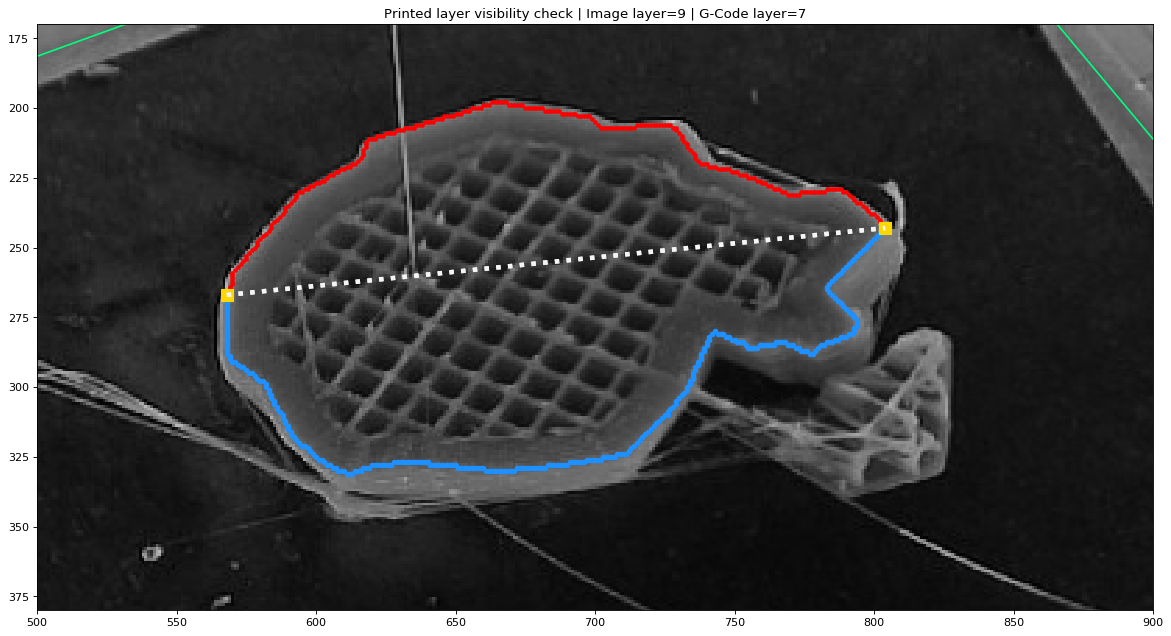

In [ ]:
# Generate a 60-pixel wide wrapped pseudo-side-view image

side_view_window_shift = 20
side_view_window_width = 40

fig = plt.figure(figsize=(18,14), dpi=80)
plt.imshow(src,cmap='gray')
plt.scatter(391,221,c='springgreen',s=30)
plt.scatter(788,77,c='springgreen',s=30)
plt.scatter(1031,368,c='springgreen',s=30)
plt.scatter(569,562,c='springgreen',s=30)

plt.plot([391,788],[221,77],c='springgreen')
plt.plot([788,1031],[77,368],c='springgreen')
plt.plot([1031,569],[368,562],c='springgreen')
plt.plot([569,391],[562,221],c='springgreen')

#plt.plot([391,1031],[221,368],c='springgreen',linestyle=':')
#plt.plot([788,569],[77,562],c='springgreen',linestyle=':')

plt.plot([np.min(Pc[:,0]),np.max(Pc[:,0])],\
                 [Pc[np.argmin(Pc[:,0])][1],Pc[np.argmax(Pc[:,0])][1]],c='whitesmoke',linewidth=4,linestyle=':')
plt.scatter(np.min(Pc[:,0]),Pc[np.argmin(Pc[:,0])][1],color='gold',marker='s',s=60)
plt.scatter(np.max(Pc[:,0]),Pc[np.argmax(Pc[:,0])][1],color='gold',marker='s',s=60)

visible_edge_x = []
visible_edge_y_top = []
visible_edge_y_bottom = []

for i in range(np.shape(Pc)[0]):
    if(Pc[i][1] > slope*Pc[i][0]+shift):
        plt.scatter(Pc[i][0],Pc[i][1],color='dodgerblue',s=16)
        visible_edge_x.append(Pc[i][0])
        visible_edge_y_top.append(Pc[i][1]-side_view_window_shift)
        visible_edge_y_bottom.append(Pc[i][1]+side_view_window_width)
    else:
        plt.scatter(Pc[i][0],Pc[i][1],color='red',s=10)
        
plt.plot([np.min(Pc[:,0]),np.max(Pc[:,0])],\
                 [Pc[np.argmin(Pc[:,0])][1],Pc[np.argmax(Pc[:,0])][1]],c='whitesmoke',linewidth=4,linestyle=':')
plt.scatter(np.min(Pc[:,0]),Pc[np.argmin(Pc[:,0])][1],color='gold',marker='s',s=100)
plt.scatter(np.max(Pc[:,0]),Pc[np.argmax(Pc[:,0])][1],color='gold',marker='s',s=100)

plt.xlim(500,900)
plt.ylim(380,170)
plt.title("Printed layer visibility check | Image layer={} | G-Code layer={}".format(LAYER_NUMBER,LAYER_NUMBER-2))
plt.show()

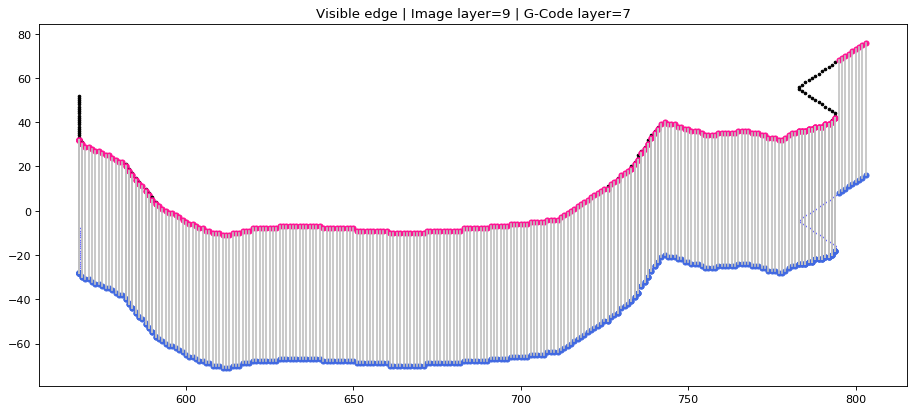

In [ ]:
# Remove contour "foldings" inside the visible region

mod_visible_edge_x = []
mod_visible_edge_y_top = []
mod_visible_edge_y_bot = []

fig = plt.figure(figsize=(14,6), dpi=80)

for i in range(np.shape(visible_edge_x)[0]):
    plt.scatter(visible_edge_x[i],300-visible_edge_y_top[i],c='k',s=5)
    plt.scatter(visible_edge_x[i],300-visible_edge_y_bottom[i],c='b',s=1)
    #plt.plot([visible_edge_x[i],visible_edge_x[i-1]],[300-visible_edge_y_top[i],300-visible_edge_y_top[i-1]],color='pink')

    x = visible_edge_x[i]
    y = visible_edge_y_top[i]
    
    if(visible_edge_x.count(visible_edge_x[i])>1):
        idx_of_multiple_xx_instances = [idx for idx, elem in enumerate(visible_edge_x) if elem == visible_edge_x[i]]
        yy_elements_of_multiple_xx = [visible_edge_y_top[idx].tolist() for idx in idx_of_multiple_xx_instances]
        x = visible_edge_x[i]
        y = np.max(yy_elements_of_multiple_xx)
    
    mod_visible_edge_x.append(x)
    mod_visible_edge_y_top.append(y)
    mod_visible_edge_y_bot.append(y+side_view_window_shift+side_view_window_width)
    
    plt.scatter(x,300-y,c='deeppink',s=20)
    plt.scatter(x,300-(y+side_view_window_shift+side_view_window_width),c='royalblue',s=20)
    
for i in range(len(mod_visible_edge_x)):
    plt.plot([mod_visible_edge_x[i],mod_visible_edge_x[i]],\
             [300-mod_visible_edge_y_top[i],300-mod_visible_edge_y_bot[i]],linestyle='-',color='silver')
    
plt.title("Visible edge | Image layer={} | G-Code layer={}".format(LAYER_NUMBER,LAYER_NUMBER-2))
plt.show()

In [ ]:
mask = np.zeros(src.shape, dtype=np.uint8)

# points format: [[(10,10), (300,300), (10,300)]]
first = [tuple(map(tuple,np.stack((mod_visible_edge_x,mod_visible_edge_y_top)).T[np.stack((mod_visible_edge_x,mod_visible_edge_y_top)).T[:,0].argsort()]))] # stl edge
second = [tuple(map(tuple,np.flipud(np.stack((mod_visible_edge_x,mod_visible_edge_y_bot)).T[np.stack((mod_visible_edge_x,mod_visible_edge_y_bot)).T[:,0].argsort()])))] # shifted edge

# 'area' - is the visible curved side-view region cleared from additional inner cross-foldings
area = [tuple(map(tuple, np.squeeze(np.concatenate((first,second),axis=1))))]

roi_corners = np.array(area, dtype=np.int32)
cv2.fillPoly(mask, roi_corners, (255, 255, 255))

# apply the mask
masked_image = cv2.bitwise_and(src, mask)

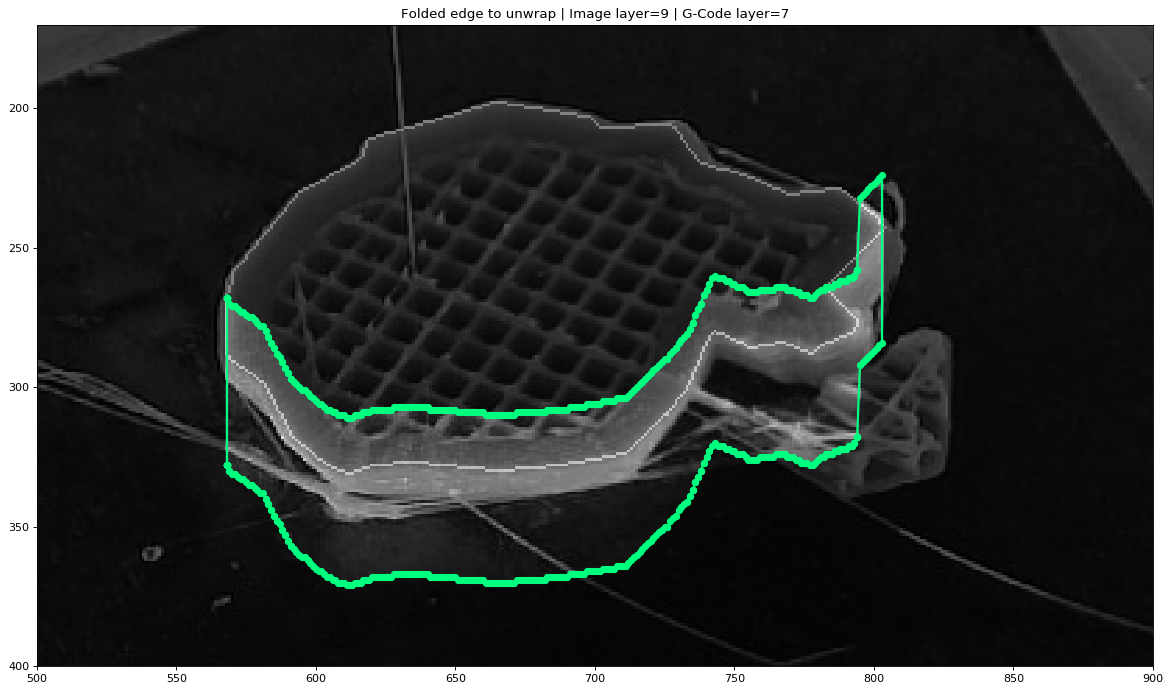

In [ ]:
# Plot the visible curved side-view region cleared from additional inner cross-foldings

fig = plt.figure(figsize=(18,14), dpi=80)
plt.imshow(src_temp,cmap='gray')
plt.imshow(masked_image,alpha=0.5,cmap='gray')

for i in range(np.shape(area)[1]):
    plt.scatter(area[0][i][0],area[0][i][1],color='springgreen',s=30)
    plt.plot([area[0][i][0],area[0][i-1][0]],[area[0][i][1],area[0][i-1][1]],color='springgreen',linewidth=2)
plt.xlim(500,900)
plt.ylim(400,170)
plt.title("Folded edge to unwrap | Image layer={} | G-Code layer={}".format(LAYER_NUMBER,LAYER_NUMBER-2))
plt.show()

In [ ]:
# 'Cut' the wrapped region from the source image

mask_edge_x = []
mask_edge_y = []

for i in range(np.shape(mask)[1]): # width
    for j in range(np.shape(mask)[0]): # height
        if (mask[j][i]==255):
            mask_edge_x.append(i)
            mask_edge_y.append(j)
            break

In [ ]:
# Generate the zeroed unwrapped placeholder

slice_height = side_view_window_shift+side_view_window_width
unwrapped = np.zeros((slice_height,np.max(mask_edge_x)-np.min(mask_edge_x)),dtype=int)
print(np.shape(unwrapped))

(60, 235)


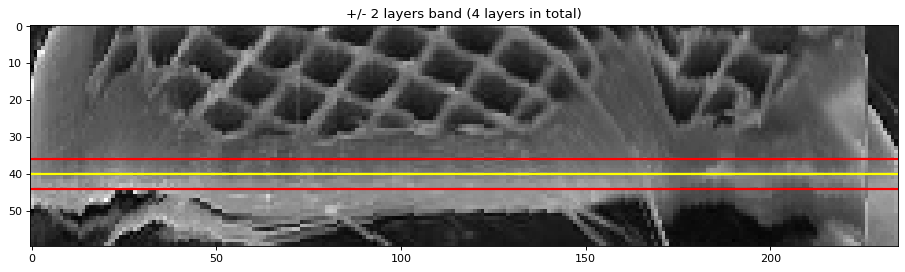

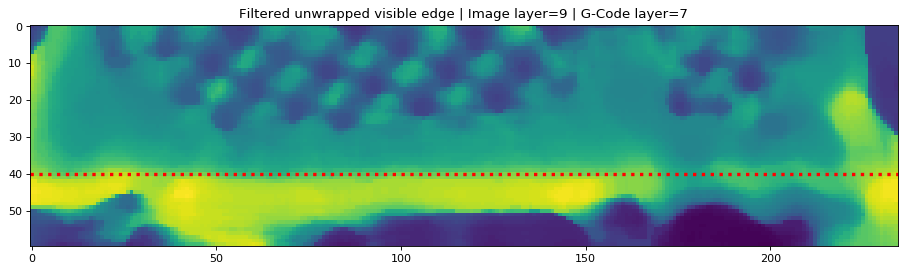

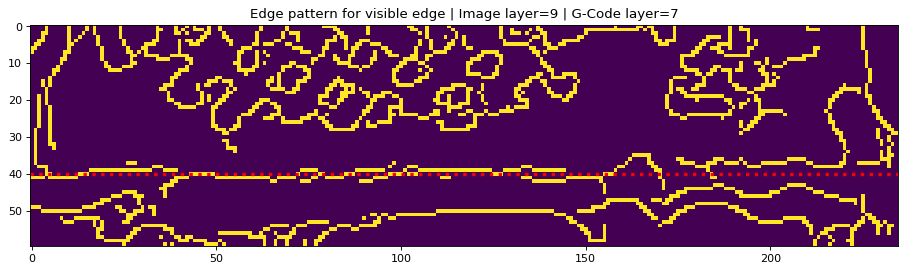

In [ ]:
# Unwrap the selected region of interest and calculate pixel-wise vertical errors

for i in range(np.max(mask_edge_x)-np.min(mask_edge_x)):
    unwrapped[:,i:i+1]=src[mask_edge_y[i]-side_view_window_shift:mask_edge_y[i]+side_view_window_width,\
                             np.min(mask_edge_x)+i:np.min(mask_edge_x)+i+1]
    
fig = plt.figure(figsize=(14,10), dpi=80)
plt.imshow(unwrapped,cmap='gray')
plt.title(' ')
# Experimentally have been found that 1 layer is equal to 2 pixels height
plt.axhline(y=36,linewidth=2, color='r',linestyle='-')
plt.axhline(y=44,linewidth=2, color='r',linestyle='-')
plt.axhline(y=40,linewidth=2, color='yellow',linestyle='-')
#plt.grid()
plt.title("+/- 2 layers band (4 layers in total)")
plt.show()

kernel = 9
src_denoised = filters.median(np.asarray((unwrapped),dtype=np.uint8),selem=np.ones((kernel,kernel)))
edges = cv2.Canny(src_denoised,20,50)

fig = plt.figure(figsize=(14,8), dpi=80)
plt.imshow(src_denoised)
plt.axhline(y=40,linewidth=3, color='r',linestyle=':')
plt.title("Filtered unwrapped visible edge | Image layer={} | G-Code layer={}".format(LAYER_NUMBER,LAYER_NUMBER-2))
plt.show()

fig = plt.figure(figsize=(14,8), dpi=80)
plt.imshow(edges,cmap="viridis")
plt.axhline(y=40,linewidth=3, color='r',linestyle=':')
plt.title("Edge pattern for visible edge | Image layer={} | G-Code layer={}".format(LAYER_NUMBER,LAYER_NUMBER-2))
plt.show()

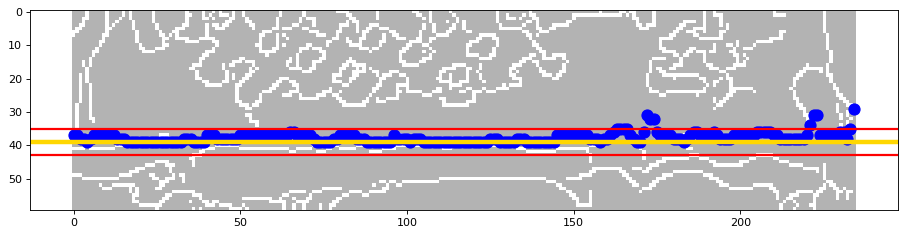

In [ ]:
# Visualize the pixel-wise vertical errors

REFERENCE_LAYER_LEVEL = 39
error_array = []

cumulative_vertical_level_error = 0
relative_vertical_level_error = 0

fig = plt.figure(figsize=(14,14), dpi=80)
#ax = plt.subplots()
#plt.imshow(np.zeros(edges.shape),cmap='gray',alpha=0.1)
plt.imshow(edges,cmap='gray',alpha=0.3)
plt.axhline(y=REFERENCE_LAYER_LEVEL,linewidth=4, color='gold',linestyle='-')

for i in range(edges.shape[1]): # horizontal
    all_vertical_edge_locations_per_x_column = [idx for idx, elem in enumerate(edges[:,i:i+1]) if elem == 255]
    if all_vertical_edge_locations_per_x_column != []:
        all_vertical_level_errors = [j - REFERENCE_LAYER_LEVEL for j in all_vertical_edge_locations_per_x_column]
    elif all_vertical_edge_locations_per_x_column == []:
        all_vertical_level_errors = REFERENCE_LAYER_LEVEL
    #print(all_vertical_edge_locations_per_x_column)
    vertical_level_error = np.min(np.abs(all_vertical_level_errors))
    error_array.append(vertical_level_error)
    #print(vertical_level_error)
    
    cumulative_vertical_level_error = cumulative_vertical_level_error+vertical_level_error
    
    plt.scatter(i,REFERENCE_LAYER_LEVEL-vertical_level_error,c='blue',s=100)
# 4 pixel height equals to two layers
plt.axhline(y=35,linewidth=2, color='red',linestyle='-')
plt.axhline(y=43,linewidth=2, color='red',linestyle='-')
#ax.set_aspect(aspect=0.5)
#plt.xlim(70,140)
#plt.ylim(50,30)
plt.show()

### <center>Side view height validation: Output data</center>

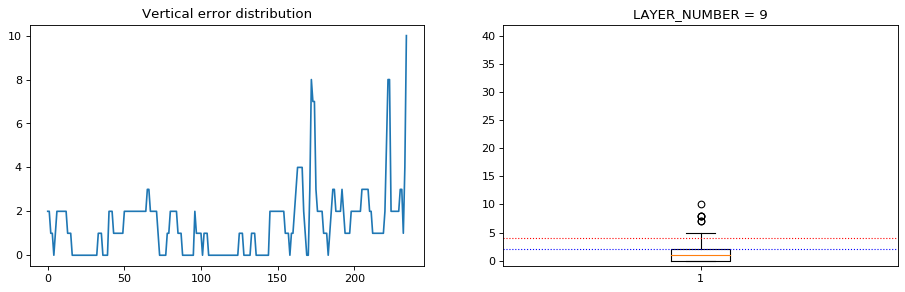

In [ ]:
fig = plt.figure(figsize=(14,4), dpi=80)
plt.subplot(121)
plt.plot(error_array)
plt.title("Vertical error distribution")
plt.subplot(122)
plt.boxplot(error_array)
plt.axhline(y=2,linewidth=1, color='b',linestyle=':') # one layer
plt.axhline(y=4,linewidth=1, color='r',linestyle=':') # two layers
plt.title("LAYER_NUMBER = {}".format(LAYER_NUMBER))
plt.ylim(-1,42)
plt.show()
plt.show()

In [ ]:
layer_width = edges.shape[1]
relative_vertical_level_error = cumulative_vertical_level_error/layer_width

print("\nSide view height validation data")
print("--------------------------------------------------------------------------------")
print('Layer width = {} px'.format(layer_width))
print('Total error of the vertical level = {} px'.format(cumulative_vertical_level_error))
print('Relative vertical error = {} (Total error / Layer width)'.format(relative_vertical_level_error))

print("\nMean error = {} px".format(np.mean(error_array)))
print("Median = {} px".format(np.median(error_array)))
print("Standard deviation = {} px".format(np.std(error_array)))
print("--------------------------------------------------------------------------------\n")


Side view height validation data
--------------------------------------------------------------------------------
Layer width = 235 px
Total error of the vertical level = 328 px
Relative vertical error = 1.3957446808510638 (Total error / Layer width)

Mean error = 1.3957446808510638 px
Median = 1.0 px
Standard deviation = 1.5077046732104542 px
--------------------------------------------------------------------------------



# <a id = 500>Global trajectory correction</a>
[Back to contents](#0)

In [77]:
# Read the rectified top view image

if(LAYER_NUMBER<10):
    #rect_top_img = cv2.imread('dataset/rect_crop/rect_crop_L0%d.jpg' %LAYER_NUMBER, 0)
    rect_top_img = cv2.imread('/home/joseph/Documents/GitHub/3D-Printer-Failure-Analysis/Computer-Vision-Models/Top-View-Model/Test-Images/printed_fox.jpg')
    
else:
    rect_top_img = cv2.imread('dataset/rect_crop/rect_crop_L%d.jpg' %LAYER_NUMBER, 0)

In [78]:
# Get mask from STL (at this precision level STL outline works as well as G-Code contour)

# Reference code from the `meshcut` Python library (MIT License)
# ------------------------------------------------------------------------
def points3d(verts, point_size=3, **kwargs):
    if 'mode' not in kwargs:
        kwargs['mode'] = 'point'
    p = mlab.points3d(verts[:, 0], verts[:, 1], verts[:, 2], **kwargs)
    p.actor.property.point_size = point_size


def trimesh3d(verts, faces, **kwargs):
    mlab.triangular_mesh(verts[:, 0], verts[:, 1], verts[:, 2], faces,
                         **kwargs)


def orthogonal_vector(v):
    """Return an arbitrary vector that is orthogonal to v"""
    if v[1] != 0 or v[2] != 0:
        c = (1, 0, 0)
    else:
        c = (0, 1, 0)
    return np.cross(v, c)


def show_plane(orig, n, scale=1.0, **kwargs):
    """
    Show the plane with the given origin and normal. scale give its size
    """
    b1 = orthogonal_vector(n)
    b1 /= la.norm(b1)
    b2 = np.cross(b1, n)
    b2 /= la.norm(b2)
    verts = [orig + scale*(-b1 - b2),
             orig + scale*(b1 - b2),
             orig + scale*(b1 + b2),
             orig + scale*(-b1 + b2)]
    faces = [(0, 1, 2), (0, 2, 3)]
    trimesh3d(np.array(verts), faces, **kwargs)
# ------------------------------------------------------------------------

In [79]:
m = stl.mesh.Mesh.from_file('/home/joseph/Documents/GitHub/3D-Printer-Failure-Analysis/Computer-Vision-Models/Top-View-Model/Test-STL/70mm_low_poly_fox_MatterControl.stl')

# Flatten vertices array
verts = m.vectors.reshape(-1, 3)
# Generate corresponding faces array
faces = np.arange(len(verts)).reshape(-1, 3)

verts, faces = meshcut.merge_close_vertices(verts, faces)

obtained_mesh = mesh.Mesh.from_file('/home/joseph/Documents/GitHub/3D-Printer-Failure-Analysis/Computer-Vision-Models/Top-View-Model/Test-STL/70mm_low_poly_fox_MatterControl.stl')

volume,cog,inertia = obtained_mesh.get_mass_properties()
print("Volume                                  = {0}".format(volume))
print("Position of the center of gravity (COG) = {0}".format(cog))
print("Inertia matrix at expressed at the COG  = {0}".format(inertia[0,:]))
print("                                          {0}".format(inertia[1,:]))
print("                                          {0}".format(inertia[2,:]))

mesh_plane = meshcut.TriangleMesh(verts,faces)

plane_orig_1 = (0, 0, z_level)
plane_norm_1 = (0, 0, 1)
plane_norm_1 /= la.norm(plane_norm_1)

stl_plane_1 = meshcut.Plane(plane_orig_1, plane_norm_1)

P0 = meshcut.cross_section_mesh(mesh_plane,meshcut.Plane((0, 0, 0), (0, 0, 1)))
P1 = meshcut.cross_section_mesh(mesh_plane,stl_plane_1)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# Double check the height of the model
part_height = np.max(obtained_mesh.vectors[:,:,2])-np.min(obtained_mesh.vectors[:,:,2])
print('Total height of the part = {} mm'.format(part_height))

Total height of the part = 70.0 mm


In [ ]:
# Add additional points to STL outline to get a dense contour

stl_outline_x = []
stl_outline_y = []
number_of_additional_points = 10

def interpolatePoints(segment_one, segment_two, additional_points_in_between):
    return zip(np.linspace(segment_one[0], segment_two[0], additional_points_in_between+1),\
               np.linspace(segment_one[1], segment_two[1], additional_points_in_between+1))
print(P1)
for i in range(np.shape(P1[0])[0]):
    for j in range(len(list(interpolatePoints((P1[0][i][0],P1[0][i][1]),(P1[0][i-1][0],P1[0][i][1]),\
                                                 number_of_additional_points)))):
        xx = list(interpolatePoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][0]
        yy = list(interpolatePoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][1]
        stl_outline_x.append(xx)
        stl_outline_y.append(yy)
    stl_outline_x.append(P1[0][i][0])
    stl_outline_y.append(P1[0][i][1])

stl_out_shape = np.vstack([(stl_outline_x),(stl_outline_y)])
stl_out_shape = np.vstack([(stl_out_shape[0]),(stl_out_shape[1])])

[]


IndexError: list index out of range

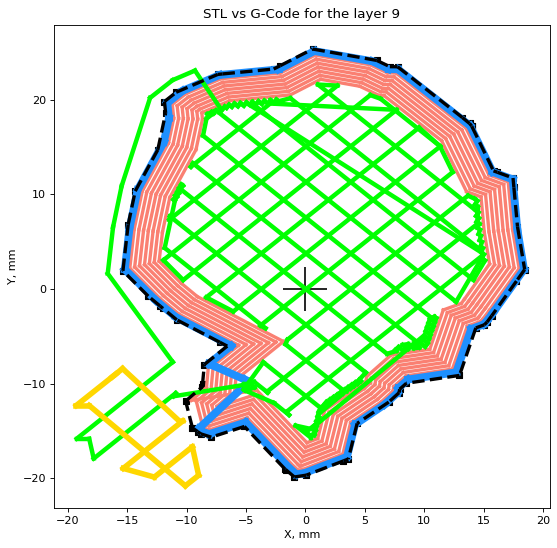

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=80)
plt.subplot(111)

for i in range(len(X_active_wall_inner)):
    #plt.scatter(X_active_wall_inner[i],Y_active_wall_inner[i],marker='s',c='k',s=10,alpha=1)
    plt.plot([X_active_wall_inner[i],X_active_wall_inner[i-1]],
        [Y_active_wall_inner[i],Y_active_wall_inner[i-1]],color='salmon',linewidth=3,alpha=1)
    
'''for i in range(len(X_active_default)):
    plt.plot([X_active_default[i],X_active_default[i-1]],
        [Y_active_default[i],Y_active_default[i-1]],color='sienna',alpha=0.3)'''

'''for i in range(len(X_active_wall_outer)):
    plt.scatter(X_active_wall_outer[i],Y_active_wall_outer[i],marker='s',c='k',s=10,alpha=1)'''

for i in range(len(X_active_wall_outer)):
    plt.plot([X_active_wall_outer[i],X_active_wall_outer[i-1]],\
        [Y_active_wall_outer[i],Y_active_wall_outer[i-1]],color='dodgerblue',linewidth=7,alpha=1)

for i in range(len(X_active_fill)):
    plt.plot([X_active_fill[i],X_active_fill[i-1]],
        [Y_active_fill[i],Y_active_fill[i-1]],color='lime',linewidth=4,alpha=1)
    
'''for i in range(len(X_active_fill)):
    plt.scatter(X_active_fill[i],Y_active_fill[i],marker='s',c='k',s=10,alpha=1)'''

for i in range(len(X_active_support)):
    plt.plot([X_active_support[i],X_active_support[i-1]],
        [Y_active_support[i],Y_active_support[i-1]],color='gold',linewidth=5,alpha=1)

for i in range(np.shape(P1[0])[0]):
    for j in range(len(list(interpolatePoints((P1[0][i][0],P1[0][i][1]),(P1[0][i-1][0],P1[0][i][1]),\
                                                 number_of_additional_points)))):
        xx = list(interpolatePoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][0]
        yy = list(interpolatePoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][1]
        #plt.scatter(xx,yy,color='b',s=20)
        stl_outline_x.append(xx)
        stl_outline_y.append(yy)

    plt.plot([P1[0][i][0],P1[0][i-1][0]],[P1[0][i][1],P1[0][i-1][1]],color='k',linewidth=3,linestyle='--')
    plt.scatter(P1[0][i][0],P1[0][i][1],marker='s',color='k',s=25)
    stl_outline_x.append(P1[0][i][0])
    stl_outline_y.append(P1[0][i][1])
plt.scatter(0,0,c='k',s=1550,marker='+')
#plt.xlim(-15, 25)
#plt.ylim(-20, 20)
ax.set_aspect(1)
plt.xlabel('X, mm')
plt.ylabel('Y, mm')
plt.title('STL vs G-Code for the layer {}'.format(LAYER_NUMBER))
plt.show()

In [ ]:
# Create mask from STL
# Apply additional transformation to the contour if necessary

def SRT(point_cloud,scale,theta,tx,ty):
    S = scale
    R = np.array([[np.cos(theta),np.sin(theta)],\
                  [-np.sin(theta),np.cos(theta)]])
    T = np.array([tx,ty])
    transformed = S*R.dot(point_cloud)+T[:,np.newaxis]
    return transformed


stl_out_shape = np.vstack([(stl_outline_x),(stl_outline_y)])
stl_out_shape = SRT(stl_out_shape,5.6,0.2,273,230)
stl_out_shape = np.vstack([(stl_out_shape[0]),(stl_out_shape[1])])

stl_mask_points = np.asarray(stl_out_shape.T.reshape((-1,2)),dtype=np.int32)
print(np.shape(stl_mask_points))

(1368, 2)


In [ ]:
# Draw the STL mask for edge detection

STL_MASK_WIDTH = 30
stl_mask = np.zeros((rect_top_img.shape),np.uint8)
cv2.polylines(stl_mask,[stl_mask_points],False,(255,255,255),STL_MASK_WIDTH)

print(np.shape(rect_top_img))
print(np.shape(stl_mask))
#print(np.shape(gcode_mask))

(500, 500)
(500, 500)


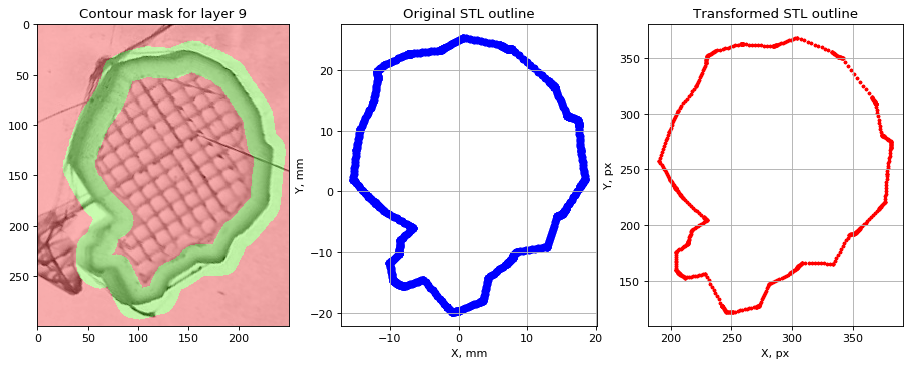

In [ ]:
fig = plt.figure(figsize=(14,5), dpi=80)
plt.subplot(131)
plt.imshow(rect_top_img[100:400,150:400],cmap='Greys')
plt.imshow(np.flip(stl_mask,0)[100:400,150:400],alpha=0.3,cmap='prism')
plt.title('Contour mask for layer {}'.format(LAYER_NUMBER))
plt.subplot(132)
plt.scatter(stl_outline_x,stl_outline_y,c='b')
plt.title("Original STL outline")
plt.xlabel("X, mm")
plt.ylabel("Y, mm")
plt.grid()
plt.subplot(133)
plt.scatter(stl_out_shape[0],stl_out_shape[1],color='r',s=5)
plt.title("Transformed STL outline")
plt.xlabel("X, px")
plt.ylabel("Y, px")
plt.grid()
plt.show()

In [ ]:
# Apply median filtration to reduce amount of visual noise
filtered_top_view = filters.median(rect_top_img,selem=np.ones((9,9)))

# Find contours using Canny edge detector
# Experimentally has been found that the 20...50 threshold range works well
top_view_edges = cv2.Canny(filtered_top_view,20,50)*(np.flip(stl_mask,0))

# But it can be more convenient to use Canny edge detector with automatic 
# parameters introduced by Adrian Rosebrock 
# (https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/)

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

edges_new = auto_canny(filtered_top_view)*(np.flip(stl_mask,0))

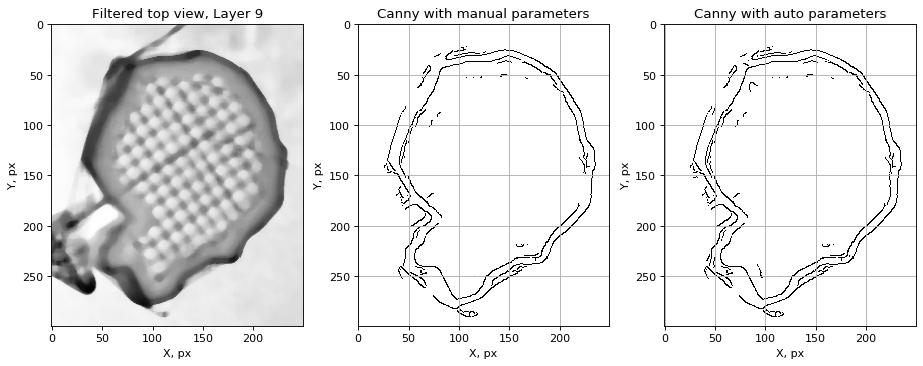

In [ ]:
fig = plt.figure(figsize=(14,5), dpi=80)
plt.subplot(131)
plt.imshow(filtered_top_view[100:400,150:400],cmap='Greys')
plt.title('Filtered top view, Layer {}'.format(LAYER_NUMBER))
plt.xlabel("X, px")
plt.ylabel("Y, px")
plt.subplot(132)
plt.imshow(top_view_edges[100:400,150:400],cmap='Greys')
plt.title("Canny with manual parameters")
plt.xlabel("X, px")
plt.ylabel("Y, px")
plt.grid()
plt.subplot(133)
plt.imshow(edges_new[100:400,150:400],cmap='Greys')
plt.title("Canny with auto parameters")
plt.xlabel("X, px")
plt.ylabel("Y, px")
plt.grid()
plt.show()

In [ ]:
# Convert detected contour into array of points for further ICP algorithm

height = np.shape(edges_new)[0]
width = np.shape(edges_new)[1]

noOfCoordinates_t = 0
coordX_t = []
coordY_t = []
edgeMagnitude_t = []
edgeDerivativeX_t = []
edgeDerivativeY_t = []

pp = np.zeros((height,width,1), dtype=np.float32)
pp = np.squeeze(pp)

RSum = 0
CSum = 0

for j in range(0,height):
    for i in range(0,width):
        if (edges_new[j][i] != 0):
            RSum = RSum+i
            CSum = CSum+j
            coordX_t.append(i)
            coordY_t.append(j)
            noOfCoordinates_t += 1
            pp[i][j]=1

center_gravity_x = RSum/(noOfCoordinates_t+1e-6)
center_gravity_y = CSum/(noOfCoordinates_t+1e-6)

detected_masked_edge_points = np.vstack([(coordX_t),(coordY_t)])

In [ ]:
# Generate a contour template for Multi Template Matching

# here we create two masks (outer and inner) from the gcode type:wall-inner
# then substact "inner" from outer" to get the gcode-precise outline

gcode_wall_inner_shape = np.vstack([(X_active_wall_inner),(Y_active_wall_inner)])
gcode_wall_inner_shape = SRT(gcode_wall_inner_shape, 5.7,0.2,273,231)
#gcode_wall_inner_shape = SRT(gcode_wall_inner_shape, 5.7,0.2,277,231)
gcode_wall_inner_mask_points = np.asarray(gcode_wall_inner_shape.T.reshape((-1,2)),dtype=np.int32)

gcode_mask_outer = np.zeros((rect_top_img.shape), np.uint8)
cv2.polylines(gcode_mask_outer,[gcode_wall_inner_mask_points],False,(200,200,200),6)

gcode_mask_inner = np.zeros((rect_top_img.shape), np.uint8)
cv2.polylines(gcode_mask_inner,[gcode_wall_inner_mask_points],False,(200,200,200),4)

print(np.shape(rect_top_img))
print(np.shape(gcode_mask_outer))
print(np.shape(gcode_mask_inner))

final_mask = np.flip(gcode_mask_outer,0)*np.flip(gcode_mask_inner,0)

(500, 500)
(500, 500)
(500, 500)


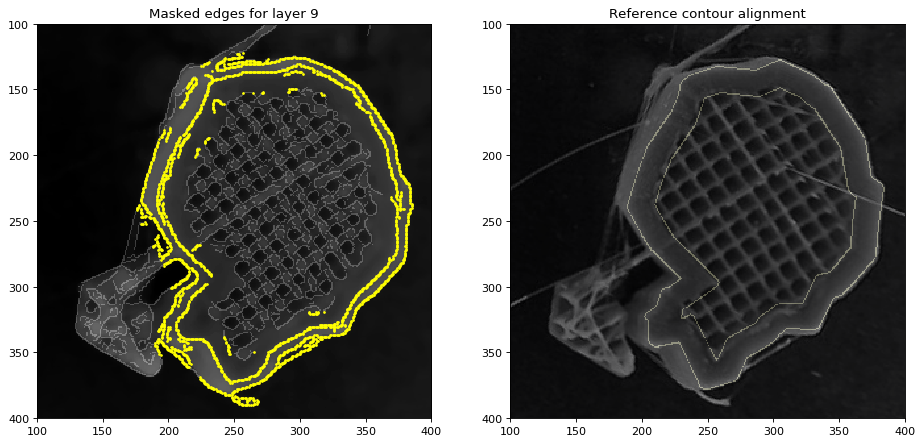

In [ ]:
fig = plt.figure(figsize=(14,10), dpi=80)
plt.subplot(121)
plt.imshow(filtered_top_view,cmap='gray')
plt.imshow(auto_canny(filtered_top_view),alpha=0.2,cmap='gray')
plt.scatter(detected_masked_edge_points[0],detected_masked_edge_points[1],s=2,c='yellow')
plt.xlim(100,400)
plt.ylim(400,100)
plt.title("Masked edges for layer {}".format(LAYER_NUMBER))
plt.subplot(122)
plt.imshow(rect_top_img,cmap='gray')
plt.imshow(np.flip(gcode_mask_outer,0)-np.flip(gcode_mask_inner,0),alpha=0.3,cmap='magma')
plt.xlim(100,400)
plt.ylim(400,100)
plt.title("Reference contour alignment")
plt.show()

(270, 270)
200
255


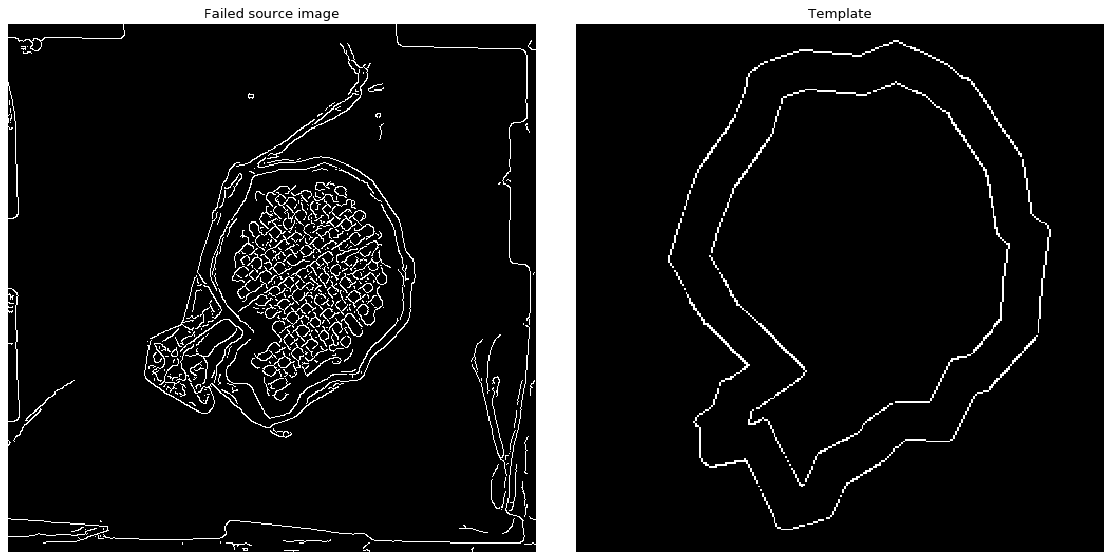

In [ ]:
# Find the part using MTM

template_to_match = np.flip(gcode_mask_outer,0)-np.flip(gcode_mask_inner,0)
template_to_match = template_to_match[120:390,142:412]
print(template_to_match.shape)

print(np.max(template_to_match))
print(np.max(auto_canny(filtered_top_view)))

fig = plt.figure(figsize=(14,10), dpi=80)
plt.subplot(121)
plt.imshow(auto_canny(filtered_top_view),cmap='gray')
plt.title('Failed source image')
plt.axis('off')
plt.subplot(122)
plt.imshow(template_to_match,cmap='gray')
plt.title('Template')
plt.tight_layout()
plt.axis('off')
plt.show()

In [ ]:
# Format the template into a list of tuple (label, templateImage)
listTemplate = [("L"+str(LAYER_NUMBER),template_to_match)]

# Find a match template in the image, if any
Hits = matchTemplates(listTemplate,auto_canny(filtered_top_view),score_threshold=0.01,\
                      method=cv2.TM_CCOEFF_NORMED,maxOverlap=0)

print("Found {} hits".format( len(Hits.index) ) )
print(Hits)

Overlay = drawBoxesOnRGB(auto_canny(filtered_top_view),Hits,showLabel=False)

Overlay[Hits.BBox[0][1]:Hits.BBox[0][1]+Hits.BBox[0][2],\
        Hits.BBox[0][0]:Hits.BBox[0][0]+Hits.BBox[0][3]] = (80,100,100)

Found 1 hits
                   BBox     Score TemplateName
0  (144, 120, 270, 270)  0.068531           L9


In [ ]:
contours, hierarchy = cv2.findContours(final_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(np.shape(contours))

(2,)


In [ ]:
# Get the points from the detected opencv contours

# ------------------------------------------- Outer Shell
img = np.zeros((rect_top_img.shape), np.uint8)

height = np.shape(final_mask)[0]
width = np.shape(final_mask)[1]

noOfCoordinates_t = 0
coordX_t = []
coordY_t = []
edgeMagnitude_t = []
edgeDerivativeX_t = []
edgeDerivativeY_t = []

shell = np.zeros((height,width,1), dtype=np.float32)
shell = np.squeeze(shell)

RSum = 0
CSum = 0

# draw contour 0
cv2.drawContours(img, contours, 0, (255,255,255), 1)

for j in range(0,height):
    for i in range(0,width):
        if (img[j][i] != 0):
            RSum = RSum+i
            CSum = CSum+j
            coordX_t.append(i)
            coordY_t.append(j)
            noOfCoordinates_t += 1
            shell[i][j]=1

center_gravity_x_outer = RSum/(noOfCoordinates_t+1e-6)
center_gravity_y_outer = CSum/(noOfCoordinates_t+1e-6)

outer_shell=np.vstack([(coordX_t),(coordY_t)])

# ------------------------------------------- Inner Shell
img = np.zeros((rect_top_img.shape), np.uint8)

height = np.shape(final_mask)[0]
width = np.shape(final_mask)[1]

noOfCoordinates_t = 0
coordX_t = []
coordY_t = []
edgeMagnitude_t = []
edgeDerivativeX_t = []
edgeDerivativeY_t = []

shell = np.zeros((height,width,1), dtype=np.float32)
shell = np.squeeze(shell)

RSum = 0
CSum = 0

# draw contour 1
if (np.shape(contours)[0]==2):
    cv2.drawContours(img, contours, 1, (255,255,255), 1)
else:
    cv2.drawContours(img, contours, 2, (255,255,255), 1)

for j in range(0,height):
    for i in range(0,width):
        if (img[j][i] != 0):
            RSum = RSum+i
            CSum = CSum+j
            coordX_t.append(i)
            coordY_t.append(j)
            noOfCoordinates_t += 1
            shell[i][j]=1

center_gravity_x_inner = RSum/(noOfCoordinates_t+1e-6)
center_gravity_y_inner = CSum/(noOfCoordinates_t+1e-6)

inner_shell=np.vstack([(coordX_t),(coordY_t)])

In [ ]:
detected_vert_shift = Hits.BBox[0][1]+Hits.BBox[0][3]/2 - center_gravity_y_outer
detected_hor_shift = Hits.BBox[0][0]+Hits.BBox[0][2]/2 - center_gravity_x_outer

print("Detected VERTICAL shift = {} px".format(detected_vert_shift))
print("Detected HORIZONTAL shift = {} px".format(detected_hor_shift))

Detected VERTICAL shift = 3.722473983827342 px
Detected HORIZONTAL shift = -1.4705878122615559 px


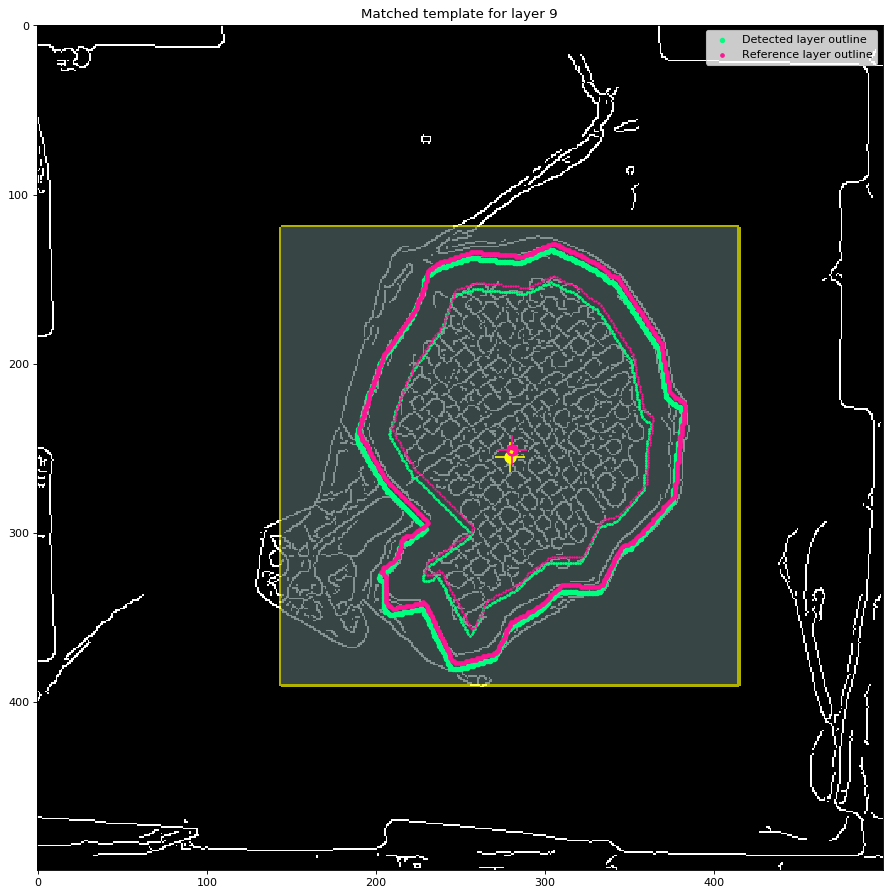

In [ ]:
fig = plt.figure(figsize=(14,14), dpi=80)
plt.imshow(auto_canny(filtered_top_view),cmap='gray')
plt.imshow(auto_canny(filtered_top_view),alpha=0.2,cmap='gray')
plt.imshow(Overlay,alpha=0.7)
plt.scatter(Hits.BBox[0][0]+Hits.BBox[0][2]/2,Hits.BBox[0][1]+Hits.BBox[0][3]/2,c='yellow',marker='+',s=750)
plt.scatter(Hits.BBox[0][0]+Hits.BBox[0][2]/2,Hits.BBox[0][1]+Hits.BBox[0][3]/2,c='yellow',marker='o',s=100)

plt.plot([center_gravity_x_outer,Hits.BBox[0][0]+Hits.BBox[0][2]/2],\
         [center_gravity_y_outer,Hits.BBox[0][1]+Hits.BBox[0][3]/2],c='yellow',linewidth=3,linestyle=':')

plt.scatter(outer_shell[0]+detected_hor_shift,\
            outer_shell[1]+detected_vert_shift,s=15,color='springgreen',label='Detected layer outline')
plt.scatter(inner_shell[0]+detected_hor_shift,\
            inner_shell[1]+detected_vert_shift,s=2,color='springgreen')

plt.scatter(outer_shell[0],outer_shell[1],s=10,color='deeppink',label='Reference layer outline')
plt.scatter(center_gravity_x_outer,center_gravity_y_outer,s=750,marker='+',color='deeppink')
plt.scatter(center_gravity_x_outer,center_gravity_y_outer,s=100,marker='o',color='deeppink')
plt.scatter(inner_shell[0],inner_shell[1],s=1,color='deeppink')
plt.title('Matched template for layer {}'.format(LAYER_NUMBER))
plt.legend()
plt.show()

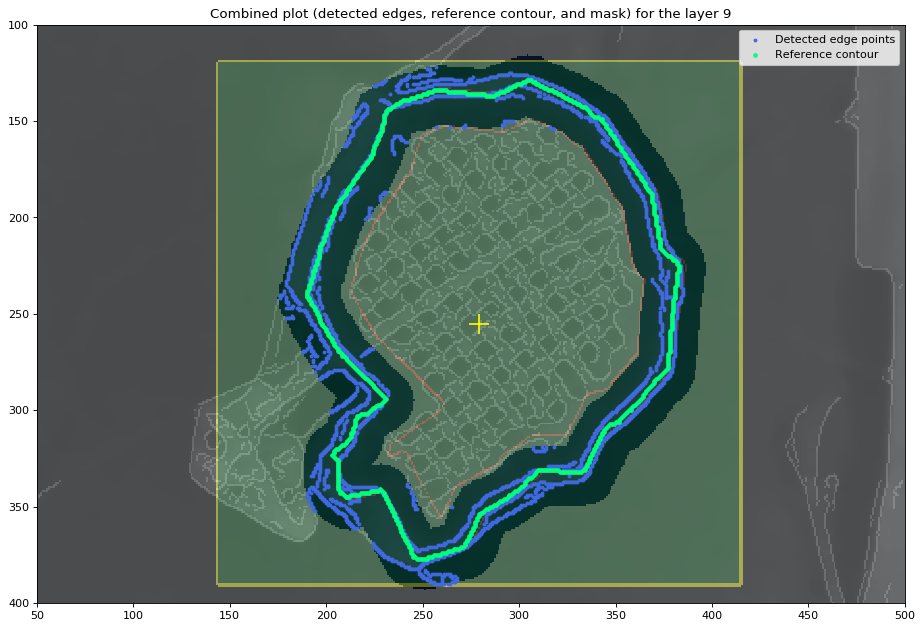

In [ ]:
Overlay = drawBoxesOnRGB(255*edges_new,Hits,showLabel=False)
#Overlay[100:150,120:150] = (255,250,20)

Overlay[Hits.BBox[0][1]:Hits.BBox[0][1]+Hits.BBox[0][2],\
        Hits.BBox[0][0]:Hits.BBox[0][0]+Hits.BBox[0][3]] = (80,85,20)
Overlay[Hits.BBox[0][1]:Hits.BBox[0][1]+Hits.BBox[0][2],\
        Hits.BBox[0][0]:Hits.BBox[0][0]+Hits.BBox[0][3],0] = template_to_match

fig = plt.figure(figsize=(14,10), dpi=80)
plt.imshow(filtered_top_view,cmap='gray')
plt.imshow(auto_canny(filtered_top_view),alpha=0.3,cmap='gray')
plt.scatter(detected_masked_edge_points[0],detected_masked_edge_points[1],s=6,c='royalblue',\
            label='Detected edge points')
plt.imshow(Overlay,alpha=0.5)
plt.scatter(Hits.BBox[0][0]+Hits.BBox[0][2]/2,Hits.BBox[0][1]+Hits.BBox[0][3]/2,c='yellow',marker='+',s=350)

plt.scatter(outer_shell[0],outer_shell[1],s=10,color='springgreen',label='Reference contour')
plt.imshow(np.flip(stl_mask,0),alpha=0.3,cmap='Blues')
#plt.scatter(center_gravity_x_outer,center_gravity_y_outer,s=250,marker='+',color='salmon')
#plt.scatter(inner_shell[0],inner_shell[1],s=5,color='deeppink')
plt.title("Combined plot (detected edges, reference contour, and mask) for the layer {}".format(LAYER_NUMBER))
plt.legend()
plt.xlim(50,500)
plt.ylim(400,100)
plt.show()

In [ ]:
# Sparse the contours to speed up the ICP algorithm

sparse_shell_x = np.delete(outer_shell[0], np.arange(0, outer_shell[0].size, 3))
sparse_shell_y = np.delete(outer_shell[1], np.arange(0, outer_shell[1].size, 3))
# sparse more
sparse_shell_x = np.delete(sparse_shell_x, np.arange(0, sparse_shell_x.size, 2))
sparse_shell_y = np.delete(sparse_shell_y, np.arange(0, sparse_shell_y.size, 2))

print('Size reduction for reference contour: {} -> {} points'.format(outer_shell[0].size,sparse_shell_x.size))
sparse_outer_shell=np.vstack([(sparse_shell_x),(sparse_shell_y)])
##########################

sparse_p_x = np.delete(detected_masked_edge_points[0],np.arange(0,detected_masked_edge_points[0].size,3))
sparse_p_y = np.delete(detected_masked_edge_points[1],np.arange(0,detected_masked_edge_points[1].size,3))

# sparse more
sparse_p_x = np.delete(sparse_p_x, np.arange(0,sparse_p_x.size,2))
sparse_p_y = np.delete(sparse_p_y, np.arange(0,sparse_p_y.size,2))

print('Size reduction for detected contour: {} -> {} points'.format(detected_masked_edge_points[0].size,sparse_p_x.size))
sparse_points=np.vstack([(sparse_p_x),(sparse_p_y)])
##########################

Size reduction for reference contour: 663 -> 221 points
Size reduction for detected contour: 2300 -> 766 points


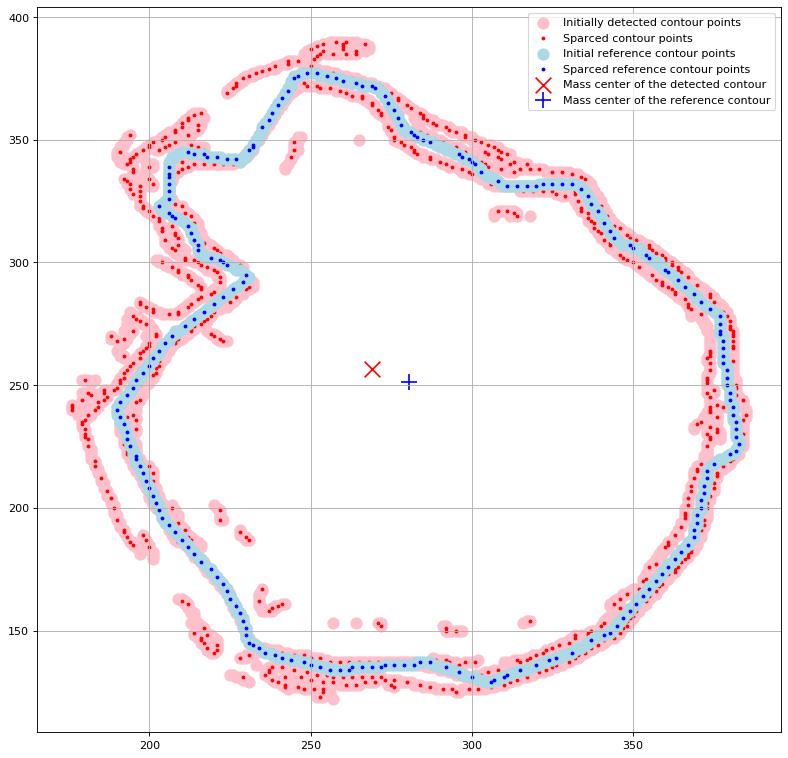

In [ ]:
# Compare the gcode points and the detected contour points

fig = plt.figure(figsize=(12,12), dpi=80)
plt.scatter(detected_masked_edge_points[0],detected_masked_edge_points[1],s=100,c='pink',\
            label='Initially detected contour points')
plt.scatter(sparse_points[0],sparse_points[1],s=6,c='red',label='Sparced contour points')
plt.scatter(outer_shell[0],outer_shell[1],s=100,color='lightblue',label='Initial reference contour points')
plt.scatter(sparse_outer_shell[0],sparse_outer_shell[1],s=6,color='blue',\
            label='Sparced reference contour points')

plt.scatter(center_gravity_x,center_gravity_y,s=200,marker='x',c='red',\
            label='Mass center of the detected contour')
plt.scatter(center_gravity_x_outer,center_gravity_y_outer,s=200,marker='+',color='blue',\
           label='Mass center of the reference contour')

plt.legend()
plt.grid()
plt.show()

In [ ]:
# Iterative Closest Points algorithm

# During the iteration step we use previously updated RTS matrix
# and recalculate correspondence between two pointclouds
def iteration_ICP(RTS,reference_point_cloud,updated_point_cloud):
    global detected_theta_total
    global detected_tr_x_total
    global detected_tr_y_total
    global detected_scale
    global total_correspondence
    err_temp = 0
    
    R = RTS[0:2,0:2]
    T = RTS[0:2,2]
    updated_point_cloud = R.dot(updated_point_cloud)+T[:,np.newaxis]
    
    # Find correspondence-------------------------
    temp_ref_ptcd = []
    for i, point in enumerate(updated_point_cloud.T):
        distances = []
        for rp in reference_point_cloud.T:
            distance_map = point[:2]-rp[:2]
            distance_norm = np.linalg.norm(distance_map)
            distances.append(distance_norm)

        if distances[np.argmin(distances)] < 25:
            temp_ref_ptcd.append(reference_point_cloud.T[np.argmin(distances)])
            
    temp_ref_ptcd = np.array(temp_ref_ptcd).T
    temp_ptcd = updated_point_cloud.copy()
    #---------------------------------------------

    for (m,n) in zip(temp_ptcd.T, temp_ref_ptcd.T):
        err_temp = np.sum(np.sqrt((np.abs(n[0])-np.abs(m[0]))**2+\
                                  (np.abs(n[1])-np.abs(m[1]))**2),\
                          axis=0)
    total_correspondence.append(err_temp)
    
    R,T,S = update_RTS(temp_ref_ptcd,temp_ptcd)
    detected_scale = 1/S

    if (R[0][0]>1.0):
        detected_theta_total = detected_theta_total + np.arccos(1)*180/np.pi
    else:
        detected_theta_total = detected_theta_total + np.arccos(R[0][0])*180/np.pi
    
    detected_tr_x_total = detected_tr_x_total + T[0]
    detected_tr_y_total = detected_tr_y_total + T[1]
    
    upd_R = RTS[0:2,0:2]
    upd_T = RTS[0:2,2]
    upd_RTS = np.eye(3,dtype=float)
    upd_RTS[0:2,0:2] = R.dot(upd_R)
    upd_RTS[0:2,2] = R.dot(upd_T)+T
    upd_RTS[2,0:2] = np.zeros(2,dtype=float)
    print('...')
    return upd_RTS


# During the update RTS step we calculate current R,T,S parameters and use them
# as initial parameters for the following ICP iteration
def update_RTS(reference_pointcloud,detected_pointcloud):
    white_detected_points = detected_pointcloud.T-np.mean(detected_pointcloud.T, axis=0)
    white_reference_points = reference_pointcloud.T-np.mean(reference_pointcloud.T, axis=0)
    
    for_singular_values = np.dot(white_detected_points.T,white_reference_points)
    U,Sigma,V = np.linalg.svd(for_singular_values.T)
    
    # Compute rotation matrix
    R = np.dot(U,V)
    # Compute translation vector
    T = np.mean(reference_pointcloud.T, axis=0)-np.dot(R,np.mean(detected_pointcloud.T, axis=0))
    # Compute scaling factor
    S = np.sqrt((np.linalg.norm(white_reference_points))**2/(np.linalg.norm(white_detected_points))**2)
    return R,T,S

In [ ]:
detected_theta_total = 0
detected_tr_x_total = 0
detected_tr_y_total = 0
detected_scale = 0
total_correspondence = []

# initial RTS transformation matrix
RTS_init = np.eye(3,dtype=float)

ICP_iterations = 5
for ICP_iteration in range(ICP_iterations):
    RTS_init = iteration_ICP(RTS_init,sparse_points,sparse_outer_shell)

print("-------------------------------------------------------")
print("Rotation detected: {} degrees".format(np.round(detected_theta_total,2)))
print("Translation detected: {} x/y units".format([np.round(-detected_tr_x_total,2),\
                                                   np.round(-detected_tr_y_total,2)]))
print("Detected scaling factor: {} %".format(np.round(detected_scale*100),2))
print("-------------------------------------------------------")

...
...
...
...
...
-------------------------------------------------------
Rotation detected: 0.21 degrees
Translation detected: [-1.17, -0.9] x/y units
Detected scaling factor: 100.0 %
-------------------------------------------------------


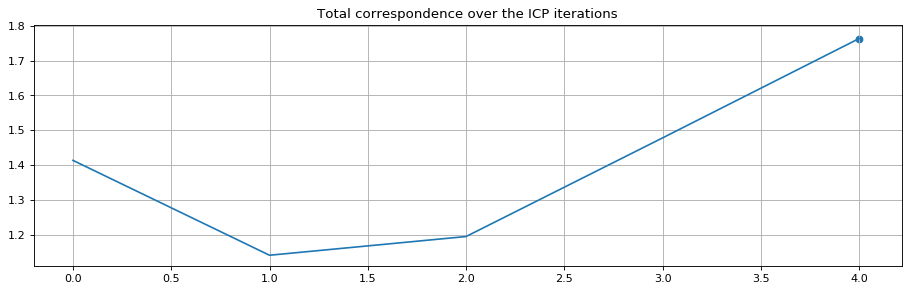

Total correspondence = 1.7629 px


In [ ]:
# Plot total correspondence between contour points over the ICP iterations

fig = plt.figure(figsize=(14,4), dpi=80)
plt.plot(total_correspondence)
plt.scatter(len(total_correspondence)-1,total_correspondence[-1])
plt.grid()
plt.title("Total correspondence over the ICP iterations")
plt.show()

print("Total correspondence = {} px". format(np.round(total_correspondence[-1],4)))

# <a id =600>Local Texture Analysis</a>
[Back to contents](#0)

In [ ]:
# Python implementation of Leung-Malik filter bank obtained from here:
# https://github.com/CVDLBOT/LM_filter_bank_python_code (Author: Tony Joseph, 2016, MIT License)

LM_filter_size = 0

def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2
    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g
    
    
def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g


def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h


def makefilter(scale, phasex, phasey, pts, sup):
    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)
    image = gx*gy
    image = np.reshape(image,(sup,sup))
    return image


def makeLMfilters():
    global LM_filter_size
    sup     = 49
    LM_filter_size = sup
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1
            
    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1
        
    return F

In [ ]:
F = makeLMfilters()
print (F.shape)
LM_bank_size = F.shape[2]
print("\nLeung-Malik bank size = {}".format(LM_bank_size))
print("Leung-Malik filter size = {} px".format(LM_filter_size))

(49, 49, 48)

Leung-Malik bank size = 48
Leung-Malik filter size = 49 px


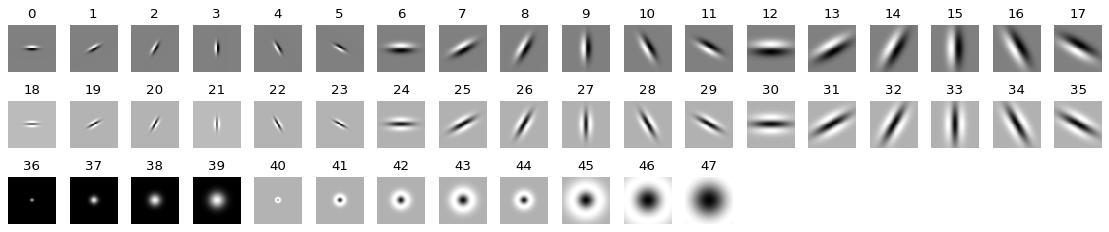

In [ ]:
# Plot Leung-Malik filter bank

fig = plt.figure(figsize=(14,3), dpi=80)
for i in range(0,LM_bank_size):
    plt.subplot(3,18,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')
    plt.tight_layout()
    plt.title(i)
plt.show()

In [ ]:
###---------------------------- Regular layer
#img = filters.median(rect_top_img,selem=np.ones((9,9)))[100:400,110:410]
#img = np.float32(img)
#texture_mask = np.zeros((rect_top_img.shape), np.uint8)
###--------------------------------------------

###---------------------------- Failure example
failure = cv2.imread('dataset/artificial_failures/rect_crop_L9.jpg', 0)
img = filters.median(failure,selem=np.ones((9,9)))[100:400,110:410]
img = np.float32(img)
texture_mask = np.zeros((rect_top_img.shape), np.uint8)
###--------------------------------------------

# Texture mask - is the infill mask which will be used later on
cv2.polylines(texture_mask,[inner_shell.T],False,(1,1,1),1)
texture_mask = texture_mask[100:400,110:410]

print(np.shape(img))

# Resize the image and texture mask to speed up texture segmentation
img = cv2.resize(img,dsize=(150,150),interpolation=cv2.INTER_CUBIC)
texture_mask = cv2.resize(texture_mask,dsize=(150,150),interpolation=cv2.INTER_CUBIC)

print(np.shape(img))
print(np.shape(texture_mask))

(300, 300)
(150, 150)
(150, 150)


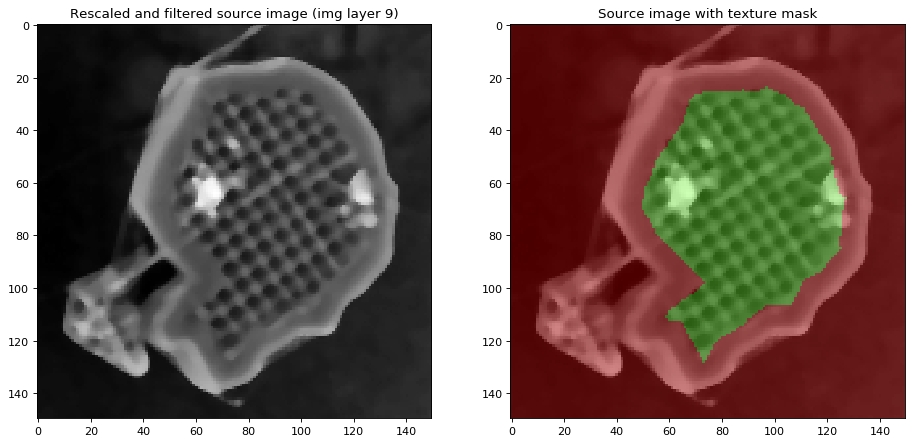

In [ ]:
fig = plt.figure(figsize=(14,10), dpi=80)
plt.subplot(121)
plt.imshow(img, cmap='gray',alpha=1)
plt.title("Rescaled and filtered source image (img layer {})".format(LAYER_NUMBER))
plt.subplot(122)
plt.imshow(img, cmap='gray',alpha=1)
plt.imshow(texture_mask, cmap='prism',alpha=0.3)
plt.title("Source image with texture mask")
plt.show()

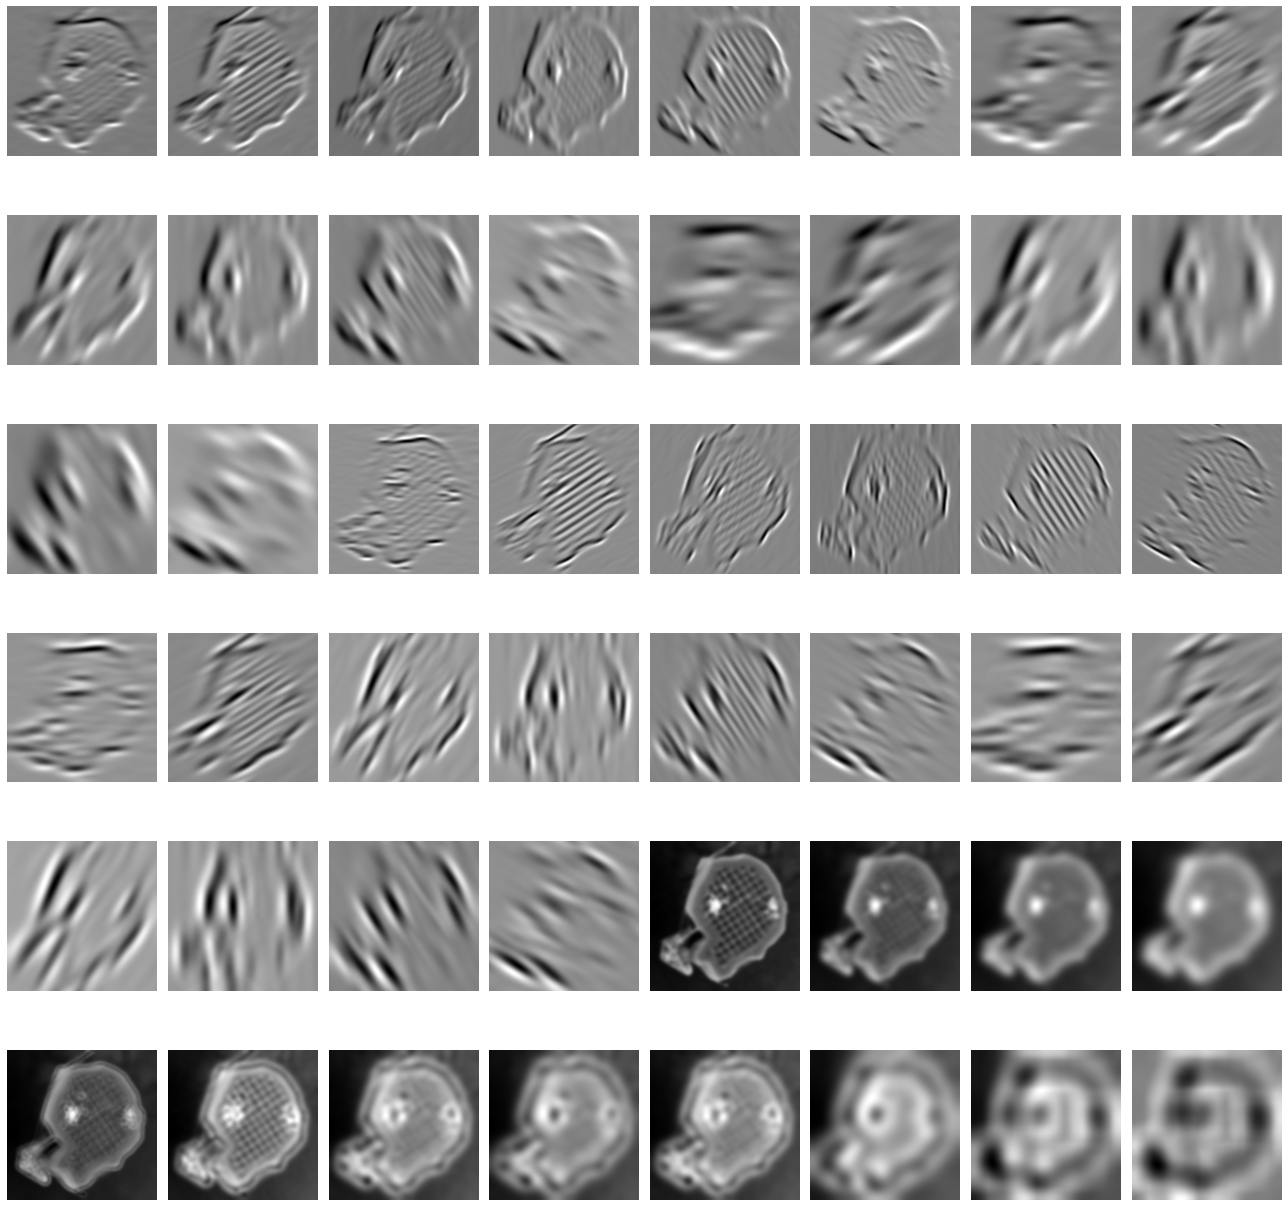

In [ ]:
# Generate filter responses
filter_response_tensor = np.zeros([img.shape[0],img.shape[1],LM_bank_size])
plt.figure(figsize=(18,18))
for i in range(0,LM_bank_size):    
    plt.subplot(6,8,i+1)
    # Get the filter responses as a tensor of convolutions
    filter_response_tensor[:,:,i] = cv2.filter2D(img,-1,F[:,:,i])
    plt.imshow(filter_response_tensor[:,:,i],cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Transform the multilayered tensor of separate filter responses
# into a single data matrix, where each response represented in row major order

print("Size of a single filter response in row major order = {}".format(img.shape[0]*img.shape[1]))
print("Initial filter response shape = {}".format(np.shape(filter_response_tensor)))

flatten_filter_response = filter_response_tensor.reshape(-1,48)
print("\nReshaped data for further segmentation = {}".format(np.shape(flatten_filter_response)))

Size of a single filter response in row major order = 22500
Initial filter response shape = (150, 150, 48)

Reshaped data for further segmentation = (22500, 48)


In [ ]:
# Normalize/Scale data
scaling_factor = np.sqrt(np.sum(flatten_filter_response**2,axis=1))

data_to_segment = np.zeros([flatten_filter_response.shape[0],flatten_filter_response.shape[1]],dtype=np.float32)
for i in range(img.shape[0]*img.shape[1]):
    data_to_segment[i,:] = flatten_filter_response[i,:]/scaling_factor[i]

In [ ]:
print("Shape of the data to segment = {}".format(np.shape(data_to_segment)))

Shape of the data to segment = (22500, 48)


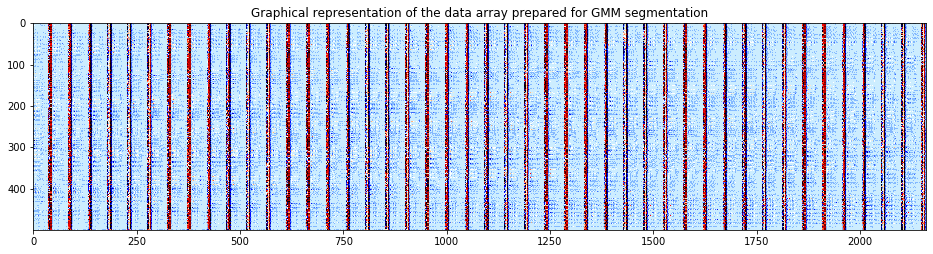

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(data_to_segment.reshape(500,2160),cmap='flag')
plt.title("Graphical representation of the data array prepared for GMM segmentation")
plt.show()

In [ ]:
# Gaussian Mixture Model Segmentation

# Experimentally was found the optimal number of texture channels
texture_channels = 6
gmm = GaussianMixture(n_components=texture_channels,random_state=3).fit(data_to_segment)
labels = gmm.predict(data_to_segment)

centers = gmm.means_
res_img = labels.reshape(img.shape[0],img.shape[1])

In [ ]:
centers.shape

(6, 48)

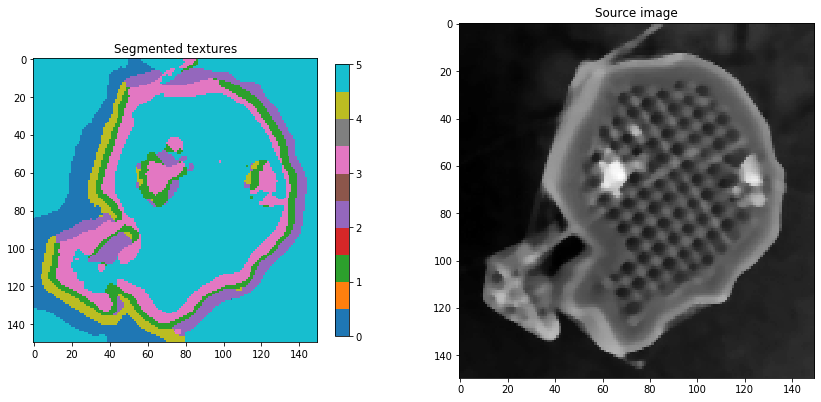

In [ ]:
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.imshow(res_img, cmap='tab10')
plt.colorbar(shrink=0.5)
plt.title("Segmented textures")
plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.title("Source image")
plt.show()

In [ ]:
# Generate graphical representations of texture channels

# "The cluster center can be visualized byapseudo-inverse which 
# transfers a feature vector intoan image icon." (Zhu et al. 2005)

# S.-C. Zhu, C.-E. Guo, Y. Wang AND Z. Xu. What are Textons? 
# International Journal of Computer Vision 62(1/2), 121–143, 2005
# http://www.stat.ucla.edu/~sczhu/papers/texton.pdf

print(np.shape(F))

flatten_filter_bank = F.reshape(-1,LM_bank_size)
print(np.shape(flatten_filter_bank))
print('--------------------------\n')

pseudo_inverted_filters = np.linalg.pinv(flatten_filter_bank)
print(np.shape(pseudo_inverted_filters))

texton_channels = np.zeros([LM_filter_size,LM_filter_size,texture_channels],dtype=np.float32)
print(np.shape(texton_channels))
print(np.shape(texton_channels[:,:,0]))
print('--------------------------\n')

print(np.shape(centers[0,:].reshape(1,LM_bank_size).T))

for i in range(texture_channels):
    image_icon = (pseudo_inverted_filters.T).dot(centers[i,:].reshape(LM_bank_size,1))
    print(image_icon.shape)
    texton_channels[:,:,i] = image_icon.reshape(LM_filter_size,LM_filter_size)
    
print('==========================')
print(np.shape(texton_channels))

(49, 49, 48)
(2401, 48)
--------------------------

(48, 2401)
(49, 49, 6)
(49, 49)
--------------------------

(48, 1)
(2401, 1)
(2401, 1)
(2401, 1)
(2401, 1)
(2401, 1)
(2401, 1)
(49, 49, 6)


In [ ]:
X = np.arange(0,LM_filter_size,1)
Y = np.arange(0,LM_filter_size,1)
X, Y = np.meshgrid(X, Y)

print(np.shape(X))

(49, 49)


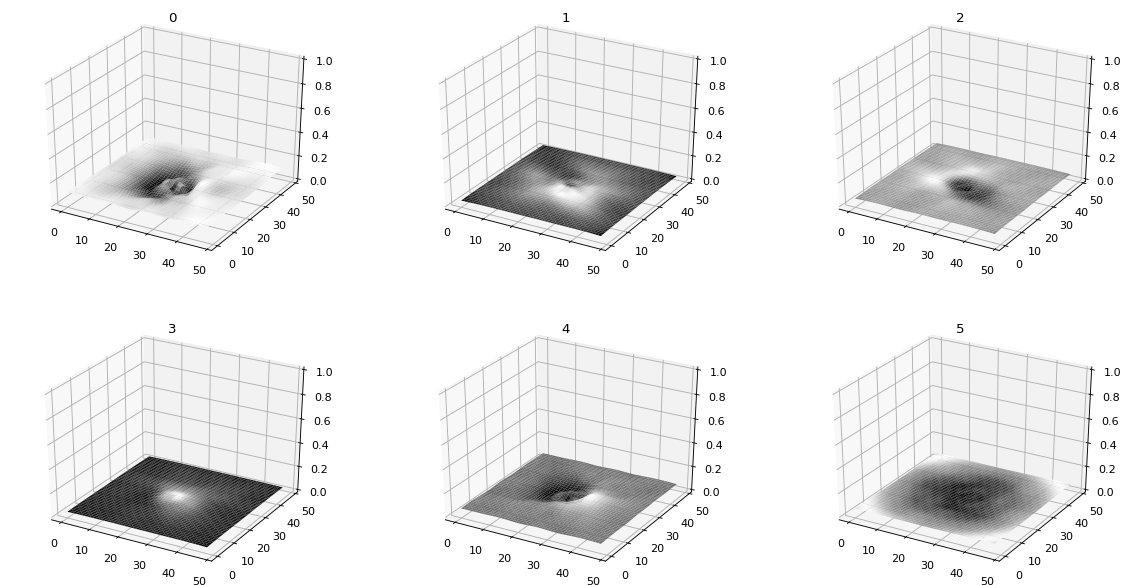

In [ ]:
# Plot texton channels as 3D surfaces

fig = plt.figure(figsize=(18,30),dpi=80)
for i in range (0,centers.shape[0]):
    ax = fig.add_subplot(6,3,i+1,projection='3d')
    surf = ax.plot_surface(X,Y,texton_channels[:,:,i],cmap='gray')
    ax.set_zlim(0,1)
    ax.grid(True)
    #ax.view_init(elev=45, azim=0)
    #ax.view_init(elev=45)
    ax.set_title(i)
plt.show()

In [ ]:
# Relabelling the whole image for regionprops

label_image = label(res_img)
image_label_overlay = label2rgb(label_image, image=img)
label_rgb = segmentation.mark_boundaries(res_img, res_img, (250, 250, 250))

/home/aloy/.local/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


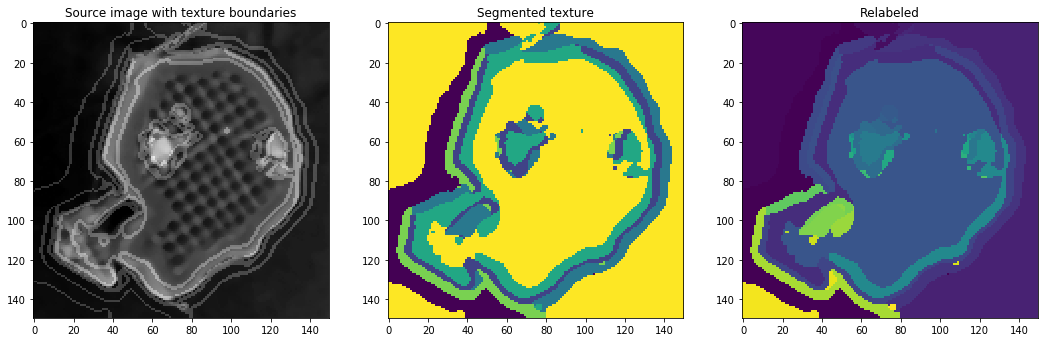

(150, 150)


In [ ]:
plt.figure(figsize=(18,14))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.imshow(label_rgb[:,:,0],alpha=0.2,cmap='gray')
plt.title("Source image with texture boundaries")
#plt.axis('Off')
plt.subplot(132)
plt.imshow(res_img) # result of GMM clustering
plt.title('Segmented texture')
plt.subplot(133)
plt.imshow(label_image) # almost the same as res_img, we use it for further centroid clustering
plt.title('Relabeled')
plt.show()

print(np.shape(img))

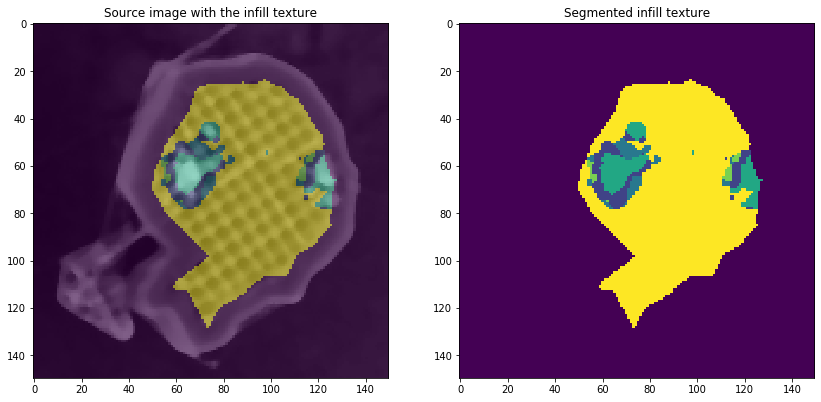

In [ ]:
# Mask the infill
# From now on, we will only work with textures inside the infill mask

label_rgb = segmentation.mark_boundaries(res_img, res_img, (250, 250, 250))

plt.figure(figsize=(14,12))
plt.subplot(121)
plt.imshow(img, cmap='gray')
#plt.imshow(img*texture_mask, cmap='jet',alpha=0.5)
#plt.imshow(label_rgb[:,:,0],alpha=0.2,cmap='gray')
plt.imshow(res_img*texture_mask,cmap='viridis',alpha=0.5)
plt.title("Source image with the infill texture")
plt.subplot(122)
plt.imshow(res_img*texture_mask,cmap='viridis')
plt.title("Segmented infill texture")
plt.show()

In [ ]:
# Assign labels to segmented infill texture

label_just_infill_mask = label(texture_mask)
infill_mask_boundaries = segmentation.mark_boundaries(texture_mask,texture_mask,(250,250,250))

In [ ]:
infill_mask_coord_X = []
infill_mask_coord_Y = []

temp = infill_mask_boundaries[:,:,0]+texture_mask

for j in range(0,texture_mask.shape[0]):
    for i in range(0,texture_mask.shape[1]):
        if (temp[i][j] >10):
            infill_mask_coord_X.append(j)
            infill_mask_coord_Y.append(i)

infill_mask_contour = np.vstack([(infill_mask_coord_X),(infill_mask_coord_Y)])

5128
5771
5128


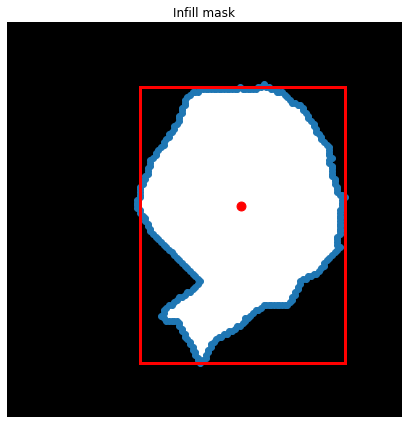

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(texture_mask,cmap='gray')
ax.scatter(infill_mask_contour[0],infill_mask_contour[1])

# It should be one region in `label_just_infill_mask`
for region in regionprops(label_just_infill_mask):
    plt.scatter(region.centroid[1],region.centroid[0],marker='o',s=80,c='red')
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,
                                  fill=False, edgecolor='red', linewidth=3)
    print(region.area)
    print(region.convex_area)
    print(region.filled_area)
    
    INFILL_AREA = region.area
    INFILL_PERIMETER = region.perimeter
    
    infill_mask_coords = region.coords
    
    ax.add_patch(rect)
ax.set_title('Infill mask')

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
infill_roi = res_img*texture_mask
label_image = label(infill_roi)

infill_raw = (res_img+1)*texture_mask
infill_raw_labeled = label(infill_raw)

failed_regions_areas = []

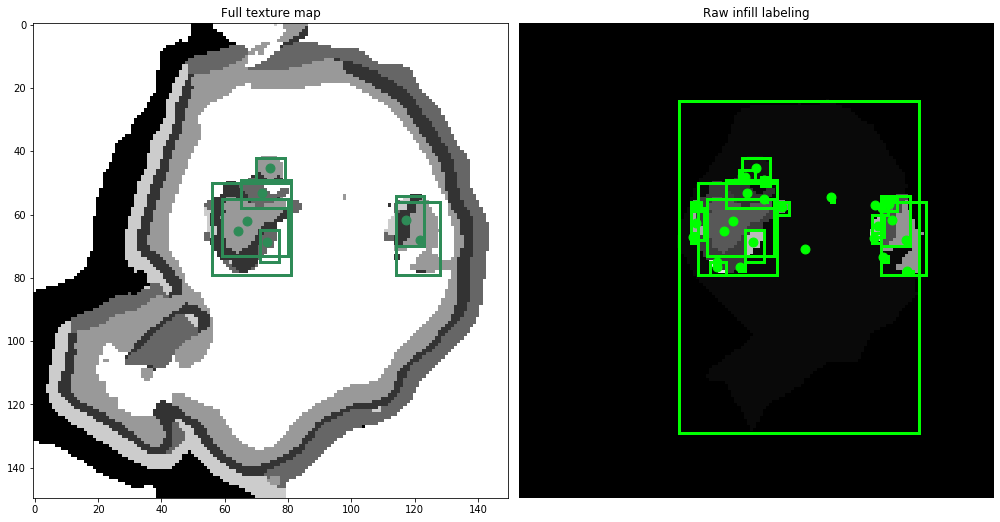

In [ ]:
# Texture blob clustering

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(121)
ax.imshow(res_img,cmap='gray')

data_list = []
centroid_list = []

MAX_AREA = 800
MIN_AREA = 30

for region in regionprops(label_image):
    if (region.area<=MAX_AREA and region.area>=MIN_AREA):
        plt.scatter(region.centroid[1],region.centroid[0],marker='o',s=80,c='seagreen')
        # draw rectangle around segmented areas
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,
                                  fill=False, edgecolor='seagreen', linewidth=3)
        ###                                             x                       y
        data_list.append([minc,maxc,minr,maxr,int(region.centroid[1]),int(region.centroid[0])])
        centroid_list.append(region.centroid)
        ax.add_patch(rect)
'''    else:
        plt.scatter(region.centroid[1],region.centroid[0],marker='x',s=100,c='red')'''
ax.set_title('Full texture map')

ax = fig.add_subplot(122)
ax.imshow(infill_raw_labeled,cmap='gray')
for region in regionprops(infill_raw_labeled):
    plt.scatter(region.centroid[1],region.centroid[0],marker='o',s=80,c='lime')
    bb_minr, bb_minc, bb_maxr, bb_maxc = region.bbox
    bb_rect = mpatches.Rectangle((bb_minc,bb_minr),bb_maxc-bb_minc,bb_maxr-bb_minr,\
                              fill=False,edgecolor='lime',linewidth=3)
    ax.add_patch(bb_rect)
    failed_regions_areas.append(region.area)
ax.set_title('Raw infill labeling')

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
AREA_OF_PRIMARY_NORMAL_TEXTURE = np.max(failed_regions_areas)
print(AREA_OF_PRIMARY_NORMAL_TEXTURE)

4253


In [ ]:
# total number of regions
print(len(failed_regions_areas)) 

# number of raw failed regions
NUMBER_OF_RAW_FAILED_REGIONS = len(failed_regions_areas)-1
print(NUMBER_OF_RAW_FAILED_REGIONS) 

26
25


In [ ]:
TOTAL_RAW_FAILED_AREA = INFILL_AREA-AREA_OF_PRIMARY_NORMAL_TEXTURE
print(TOTAL_RAW_FAILED_AREA)

RELATIVE_RAW_FAILED_AREA = TOTAL_RAW_FAILED_AREA/(NUMBER_OF_RAW_FAILED_REGIONS+1e-6)
print(RELATIVE_RAW_FAILED_AREA)

875
34.999998600000055


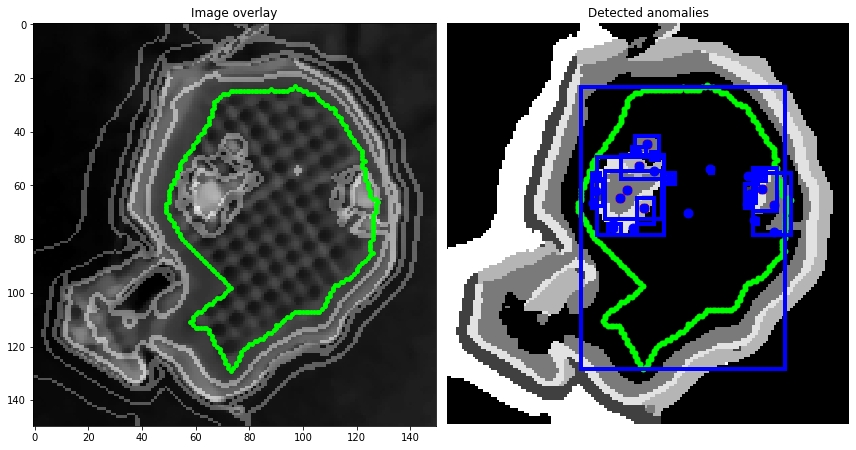

LAYER NUMBER = 9

------------------------------------------------------------
Number of abnormal regions within the infill area = 25

Area of the infill region = 5128 px2
Area of primary normal texture within the infill area = 4253 px2

Perimeter of the whole infill region = 318.6761902332485 px

------------------------------------------------------------
Total raw abnormal area within the infill region = 875 px2
Relative abnormal area within the infill region = 875 / 25 = 34.999998600000055 px2
------------------------------------------------------------
All infill areas: = [   1    1    1    2    2    3    4    5    6    6    7    7    8   11
   11   11   18   19   36   51   62   69  129  199  206 4253] px2



In [ ]:
# Data

fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(121)
ax.imshow(img, cmap='gray')
ax.imshow(label_rgb[:,:,0],alpha=0.3,cmap='gray')
ax.scatter(infill_mask_contour[0],infill_mask_contour[1],c='lime',s=15)
ax.set_title('Image overlay')
ax.set_axis_on()

ax = fig.add_subplot(122)
ax.imshow(res_img,cmap='Greys')
ax.scatter(infill_mask_contour[0],infill_mask_contour[1],c='lime',s=25)
data_list = []
centroid_list = []


for region in regionprops(label_image):
    if (region.area<=MAX_AREA and region.area>=MIN_AREA):
        plt.scatter(region.centroid[1],region.centroid[0],marker='X',s=80,c='red')
        # draw rectangle around segmented areas
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,
                                  fill=False, edgecolor='red', linewidth=3)
        ###                                             x                       y
        data_list.append([minc,maxc,minr,maxr,int(region.centroid[1]),int(region.centroid[0])])
        centroid_list.append(region.centroid)
        ax.add_patch(rect)
        
for region in regionprops(infill_raw_labeled):
    plt.scatter(region.centroid[1],region.centroid[0],marker='o',s=80,c='blue')
    bb_minr, bb_minc, bb_maxr, bb_maxc = region.bbox
    bb_rect = mpatches.Rectangle((bb_minc,bb_minr),bb_maxc-bb_minc,bb_maxr-bb_minr,\
                              fill=False,edgecolor='blue',linewidth=4)
    ax.add_patch(bb_rect)

ax.set_title('Detected anomalies')
ax.set_xlim(0,res_img.shape[0])
ax.set_ylim(res_img.shape[1],0)
ax.set_axis_off()

plt.tight_layout()
plt.show()

################################### DATA #############################################
print("LAYER NUMBER = {}".format(LAYER_NUMBER))

print("\n------------------------------------------------------------")
#print("Number of failure clusters within the infill area = {}".format(NUMBER_OF_CLUSTERS))

# total raw infill labeling - 1 (because 1 primary label - is regular texture)
print("Number of abnormal regions within the infill area = {}".format(NUMBER_OF_RAW_FAILED_REGIONS))

print("\nArea of the infill region = {} px2".format(INFILL_AREA))
print("Area of primary normal texture within the infill area = {} px2".format(AREA_OF_PRIMARY_NORMAL_TEXTURE))
print("\nPerimeter of the whole infill region = {} px".format(INFILL_PERIMETER))

print("\n------------------------------------------------------------")

print("Total raw abnormal area within the infill region = {} px2".format(TOTAL_RAW_FAILED_AREA))
print("Relative abnormal area within the infill region = {} / {} = {} px2".format(TOTAL_RAW_FAILED_AREA,\
                                        NUMBER_OF_RAW_FAILED_REGIONS,RELATIVE_RAW_FAILED_AREA))
print("------------------------------------------------------------")
print("All infill areas: = {} px2\n".format(np.sort(failed_regions_areas)))
#print(np.sort(failed_regions_areas))

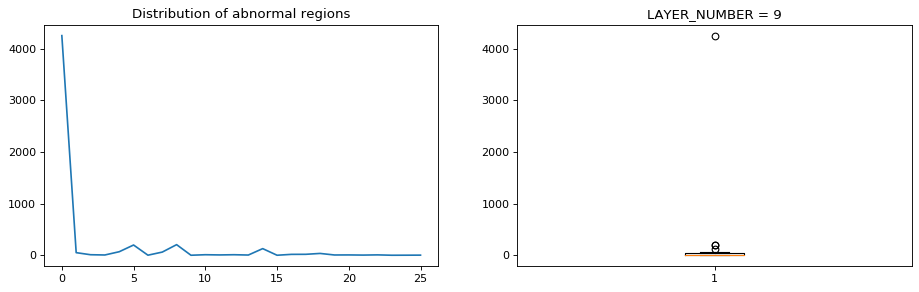

In [ ]:
fig = plt.figure(figsize=(14,4), dpi=80)
plt.subplot(121)
plt.plot(failed_regions_areas)
plt.title("Distribution of abnormal regions")
plt.subplot(122)
plt.boxplot(failed_regions_areas)
plt.title("LAYER_NUMBER = {}".format(LAYER_NUMBER))
plt.show()

In [ ]:
max_distance_between_centroids = -1

if (len(centroid_list)!=0):
    max_distance_between_centroids = np.max(distance.cdist(centroid_list,centroid_list,'euclidean'))
print("Max distance between centroids = {} px".format(np.round(max_distance_between_centroids,2)))

Max distance between centroids = 57.51 px


In [ ]:
# If it is one centroid or more of them with maximum distance between the centroids <= critical_max :
#     ->then it should be ONE cluster 
# else if (if it is more than one centroid or more of them with max distance > critical_max):
#     -> then it should be TWO clusters
# else if (it is only one centroid):
#     -> then the distance=0 (so no need to check the number of centroids)

In [ ]:
CRITICAL_CENTROID_DISTANCE = 40

if (max_distance_between_centroids>0 and max_distance_between_centroids<CRITICAL_CENTROID_DISTANCE):
    NUMBER_OF_CLUSTERS = 1
elif (max_distance_between_centroids>0 and max_distance_between_centroids>CRITICAL_CENTROID_DISTANCE):
    NUMBER_OF_CLUSTERS = 2
elif (max_distance_between_centroids<0):
    NUMBER_OF_CLUSTERS = 0
else:
    NUMBER_OF_CLUSTERS = 0

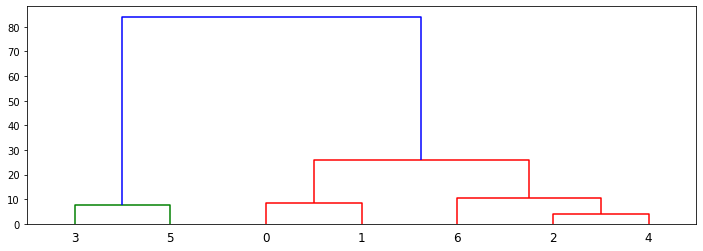

In [ ]:
if (NUMBER_OF_CLUSTERS >1 and NUMBER_OF_CLUSTERS !=1):
    plt.figure(figsize=(12,4))
    dendrogram = sch.dendrogram(sch.linkage(centroid_list, method='ward'))

In [ ]:
#centroid_list = centroid_list.append(centroid_list[0])
if (len(centroid_list) == 1):
    centroid_list = np.vstack((centroid_list[0],centroid_list[0]))
    data_list = np.vstack((data_list[0],data_list[0]))
    
data_list = np.asarray(data_list,dtype=int)
centroid_list = np.asarray(centroid_list,dtype=int)

In [ ]:
if (NUMBER_OF_CLUSTERS != 0):
    model = AgglomerativeClustering(n_clusters=NUMBER_OF_CLUSTERS, affinity='euclidean', linkage='ward')
    model.fit(centroid_list)
    labels = model.labels_

In [ ]:
labels

array([0, 0, 0, 1, 0, 1, 0])

In [ ]:
NUMBER_OF_CLUSTERS

2

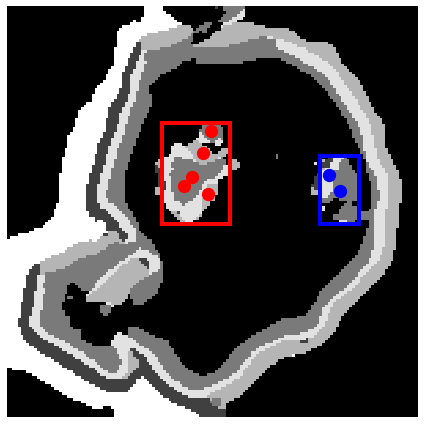

In [ ]:
# Number of LABELS equals to NUMBER_OF_CLUSTERS
# we know what where are NUMBER_OF_CLUSTERS labels, 
# so let's create NUMBER_OF_CLUSTERS min/max regions for all the labeled frames
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)
ax.imshow(res_img,cmap='Greys')
plt.scatter(centroid_list[labels==0, 1], centroid_list[labels==0, 0], s=150, marker='o', color='red')
if (NUMBER_OF_CLUSTERS !=1):
    plt.scatter(centroid_list[labels==1, 1], centroid_list[labels==1, 0], s=150, marker='o', color='blue')
#data_list = [minc,maxc,minr,maxr,centr_x,centr_y]

### for label 0
min_minc_0 = np.min(data_list[labels==0][:,0])
min_minr_0 = np.min(data_list[labels==0][:,2])
max_maxc_0 = np.max(data_list[labels==0][:,1])
max_maxr_0 = np.max(data_list[labels==0][:,3])

### for label 1
if (NUMBER_OF_CLUSTERS !=1):
    min_minc_1 = np.min(data_list[labels==1][:,0])
    min_minr_1 = np.min(data_list[labels==1][:,2])
    max_maxc_1 = np.max(data_list[labels==1][:,1])
    max_maxr_1 = np.max(data_list[labels==1][:,3])


rect_0 = mpatches.Rectangle((min_minc_0,min_minr_0),max_maxc_0-min_minc_0,\
                          max_maxr_0-min_minr_0,fill=False, edgecolor='red', linewidth=4)
if (NUMBER_OF_CLUSTERS !=1):
    rect_1 = mpatches.Rectangle((min_minc_1,min_minr_1),max_maxc_1-min_minc_1,\
                          max_maxr_1-min_minr_1,fill=False, edgecolor='blue', linewidth=4)

ax.add_patch(rect_0)
if (NUMBER_OF_CLUSTERS !=1):
    ax.add_patch(rect_1)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
### Check if region is in the labelled area

failure_patch_1 = np.zeros((1,2),dtype=int)
failure_patch_2 = np.zeros((1,2),dtype=int)

for region in regionprops(label_image):
    if (region.area<=MAX_AREA and region.area>=MIN_AREA):
        if (int(region.centroid[1]) in centroid_list[labels==0, 1]) \
        and (int(region.centroid[0]) in centroid_list[labels==0, 0]):
            failure_patch_1 = np.vstack((failure_patch_1,region.coords))
        elif (int(region.centroid[1]) in centroid_list[labels==1, 1]) \
        and (int(region.centroid[0]) in centroid_list[labels==1, 0]):
            failure_patch_2 = np.vstack((failure_patch_2,region.coords))
            
failure_patch_1 = failure_patch_1[1:-1,:] # remove first zero row
if (NUMBER_OF_CLUSTERS !=1):
    failure_patch_2 = failure_patch_2[1:-1,:] # remove first zero row

In [ ]:
TOTAL_FAILED_AREA = 0

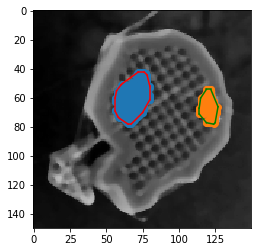

In [ ]:
failure_convex_hull_1 = ConvexHull(failure_patch_1)
if (NUMBER_OF_CLUSTERS !=1):
    failure_convex_hull_2 = ConvexHull(failure_patch_2)
    
plt.plot(failure_patch_1[:,1],failure_patch_1[:,0],'o')
if (NUMBER_OF_CLUSTERS !=1):
    plt.plot(failure_patch_2[:,1],failure_patch_2[:,0],'o')
    
plt.imshow(img,cmap='gray')

if (NUMBER_OF_CLUSTERS ==1):
    for simplex in failure_convex_hull_1.simplices:
        plt.plot(failure_patch_1[simplex,1],failure_patch_1[simplex,0],'r-')
        TOTAL_FAILED_AREA = failure_convex_hull_1.area
else:
    for simplex in failure_convex_hull_1.simplices:
        plt.plot(failure_patch_1[simplex,1],failure_patch_1[simplex,0],'r-')
        TOTAL_FAILED_AREA = failure_convex_hull_1.area
    for simplex in failure_convex_hull_2.simplices:
        plt.plot(failure_patch_2[simplex,1],failure_patch_2[simplex,0],'g-')
        TOTAL_FAILED_AREA = failure_convex_hull_1.area + failure_convex_hull_2.area
        
plt.show()

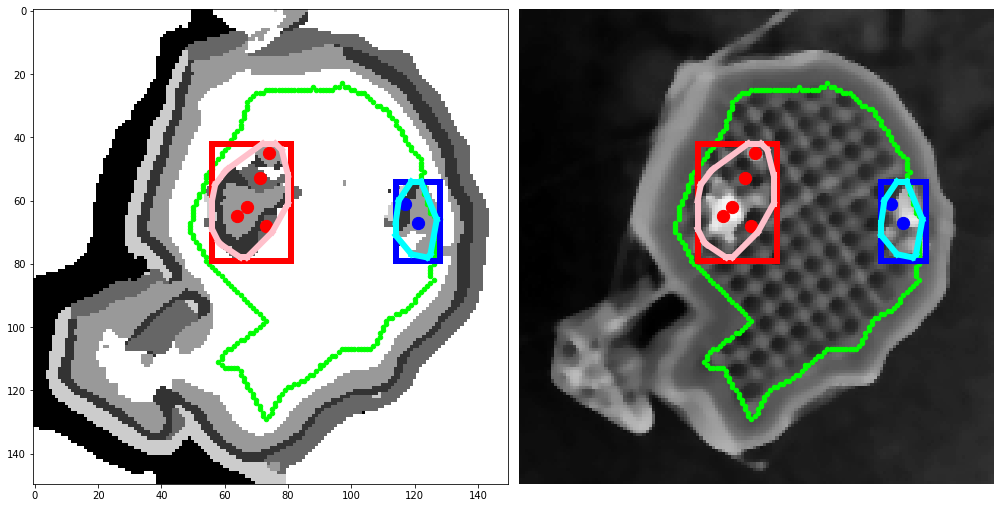

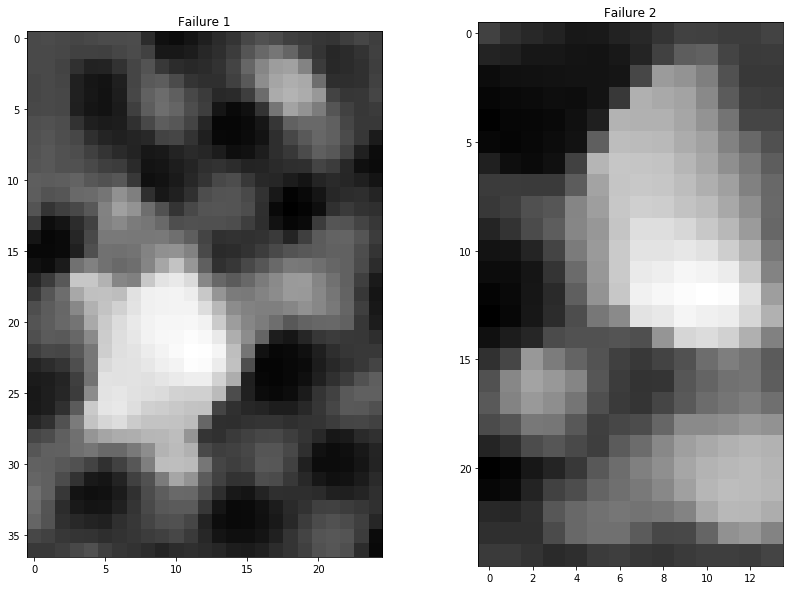

In [ ]:
# Number of LABELS equals to NUMBER_OF_CLUSTERS
# we know what where are NUMBER_OF_CLUSTERS labels, 
# so let's create NUMBER_OF_CLUSTERS min/max regions for all the labeled frames
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(121)
ax.imshow(res_img,cmap='gray')
plt.scatter(infill_mask_contour[0],infill_mask_contour[1],s=20,c='lime')
plt.scatter(centroid_list[labels==0, 1], centroid_list[labels==0, 0], s=150, marker='o', color='red')
if (NUMBER_OF_CLUSTERS !=1):
    plt.scatter(centroid_list[labels==1, 1], centroid_list[labels==1, 0], s=150, marker='o', color='blue')
#data_list = [minc,maxc,minr,maxr,centr_x,centr_y]

### for label 0
min_minc_0 = np.min(data_list[labels==0][:,0])
min_minr_0 = np.min(data_list[labels==0][:,2])
max_maxc_0 = np.max(data_list[labels==0][:,1])
max_maxr_0 = np.max(data_list[labels==0][:,3])

### for label 1
if (NUMBER_OF_CLUSTERS !=1):
    min_minc_1 = np.min(data_list[labels==1][:,0])
    min_minr_1 = np.min(data_list[labels==1][:,2])
    max_maxc_1 = np.max(data_list[labels==1][:,1])
    max_maxr_1 = np.max(data_list[labels==1][:,3])


rect_0 = mpatches.Rectangle((min_minc_0,min_minr_0),max_maxc_0-min_minc_0,\
                          max_maxr_0-min_minr_0,fill=False, edgecolor='red', linewidth=6)
if (NUMBER_OF_CLUSTERS !=1):
    rect_1 = mpatches.Rectangle((min_minc_1,min_minr_1),max_maxc_1-min_minc_1,\
                          max_maxr_1-min_minr_1,fill=False, edgecolor='blue', linewidth=6)

ax.add_patch(rect_0)
if (NUMBER_OF_CLUSTERS !=1):
    ax.add_patch(rect_1)
    
for simplex in failure_convex_hull_1.simplices:
    plt.plot(failure_patch_1[simplex,1],failure_patch_1[simplex,0],'pink',linewidth=6)
if (NUMBER_OF_CLUSTERS !=1):
    for simplex in failure_convex_hull_2.simplices:
        plt.plot(failure_patch_2[simplex,1],failure_patch_2[simplex,0],'cyan',linewidth=6)

ax = fig.add_subplot(122)
ax.imshow(img,cmap='gray')
plt.scatter(infill_mask_contour[0],infill_mask_contour[1],s=20,c='lime')
plt.scatter(centroid_list[labels==0, 1], centroid_list[labels==0, 0], s=150, marker='o', color='red')
if (NUMBER_OF_CLUSTERS !=1):
    plt.scatter(centroid_list[labels==1, 1], centroid_list[labels==1, 0], s=150, marker='o', color='blue')
#data_list = [minc,maxc,minr,maxr,centr_x,centr_y]

### for label 0
min_minc_0 = np.min(data_list[labels==0][:,0])
min_minr_0 = np.min(data_list[labels==0][:,2])
max_maxc_0 = np.max(data_list[labels==0][:,1])
max_maxr_0 = np.max(data_list[labels==0][:,3])

### for label 1
if (NUMBER_OF_CLUSTERS !=1):
    min_minc_1 = np.min(data_list[labels==1][:,0])
    min_minr_1 = np.min(data_list[labels==1][:,2])
    max_maxc_1 = np.max(data_list[labels==1][:,1])
    max_maxr_1 = np.max(data_list[labels==1][:,3])


rect_0 = mpatches.Rectangle((min_minc_0,min_minr_0),max_maxc_0-min_minc_0,\
                          max_maxr_0-min_minr_0,fill=False, edgecolor='red', linewidth=6)
if (NUMBER_OF_CLUSTERS !=1):
    rect_1 = mpatches.Rectangle((min_minc_1,min_minr_1),max_maxc_1-min_minc_1,\
                          max_maxr_1-min_minr_1,fill=False, edgecolor='blue', linewidth=6)

ax.add_patch(rect_0)
if (NUMBER_OF_CLUSTERS !=1):
    ax.add_patch(rect_1)
    
for simplex in failure_convex_hull_1.simplices:
    plt.plot(failure_patch_1[simplex,1],failure_patch_1[simplex,0],'pink',linewidth=6)
if (NUMBER_OF_CLUSTERS !=1):
    for simplex in failure_convex_hull_2.simplices:
        plt.plot(failure_patch_2[simplex,1],failure_patch_2[simplex,0],'cyan',linewidth=6)


ax.set_axis_off()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,10))
if(NUMBER_OF_CLUSTERS == 1):
    plt.imshow(img[min_minr_0:max_maxr_0,min_minc_0:max_maxc_0],cmap='gray')
    plt.title('Failure 1')
else:
    plt.subplot(121)
    plt.imshow(img[min_minr_0:max_maxr_0,min_minc_0:max_maxc_0],cmap='gray')
    plt.title('Failure 1')
    plt.subplot(122)
    plt.imshow(img[min_minr_1:max_maxr_1,min_minc_1:max_maxc_1],cmap='gray')
    plt.title('Failure 2')
plt.show()

# Summary for the layer

### Side view height validation: Output data

In [ ]:
layer_width = edges.shape[1]
relative_vertical_level_error = cumulative_vertical_level_error/layer_width

print('Layer width = {} px'.format(layer_width))
print('Total error of the vertical level = {} px'.format(cumulative_vertical_level_error))
print('Relative vertical error = {} (Total error / Layer width)'.format(relative_vertical_level_error))

print("\nMean error = {} px".format(np.mean(error_array)))
print("Median = {} px".format(np.median(error_array)))
print("Standard deviation = {} px".format(np.std(error_array)))

Layer width = 235 px
Total error of the vertical level = 328 px
Relative vertical error = 1.3957446808510638 (Total error / Layer width)

Mean error = 1.3957446808510638 px
Median = 1.0 px
Standard deviation = 1.5077046732104542 px


### Global trajectory matching: Output data

In [ ]:
# MTM
print("Detected VERTICAL shift = {} px".format(np.round(detected_vert_shift,2)))
print("Detected HORIZONTAL shift = {} px".format(np.round(detected_hor_shift,2)))

Detected VERTICAL shift = 3.72 px
Detected HORIZONTAL shift = -1.47 px


In [ ]:
# ICP
print("-------------------------------------------------------")
print("Rotation detected: {} degrees".format(np.round(detected_theta_total,2)))
print("Translation detected: {} x/y units".format([np.round(-detected_tr_x_total,2),\
                                                   np.round(-detected_tr_y_total,2)]))
print("Detected scaling factor: {} %".format(np.round(detected_scale*100),2))
print("-------------------------------------------------------")
print("Total correspondence = {} px". format(np.round(total_correspondence[-1],4)))

-------------------------------------------------------
Rotation detected: 0.21 degrees
Translation detected: [-1.17, -0.9] x/y units
Detected scaling factor: 100.0 %
-------------------------------------------------------
Total correspondence = 1.7629 px


### Local texture analysis: Output data

In [ ]:
print("LAYER NUMBER = {}".format(LAYER_NUMBER))

print("\n------------------------------------------------------------")
#print("Number of failure clusters within the infill area = {}".format(NUMBER_OF_CLUSTERS))

# total raw infill labeling - 1 (because 1 primary label - is regular texture)
print("Number of abnormal regions within the infill area = {}".format(NUMBER_OF_RAW_FAILED_REGIONS))

print("\nArea of the infill region = {} px2".format(INFILL_AREA))
print("Area of primary normal texture within the infill area = {} px2".format(AREA_OF_PRIMARY_NORMAL_TEXTURE))
print("\nPerimeter of the whole infill region = {} px".format(INFILL_PERIMETER))

print("\n------------------------------------------------------------")

print("Total raw abnormal area within the infill region = {} px2".format(TOTAL_RAW_FAILED_AREA))
print("Relative abnormal area within the infill region = {} / {} = {} px2".format(TOTAL_RAW_FAILED_AREA,\
                                        NUMBER_OF_RAW_FAILED_REGIONS,RELATIVE_RAW_FAILED_AREA))
print("------------------------------------------------------------")
print("All infill areas: = {} px2\n".format(np.sort(failed_regions_areas)))
#print(np.sort(failed_regions_areas))

LAYER NUMBER = 9

------------------------------------------------------------
Number of abnormal regions within the infill area = 25

Area of the infill region = 5128 px2
Area of primary normal texture within the infill area = 4253 px2

Perimeter of the whole infill region = 318.6761902332485 px

------------------------------------------------------------
Total raw abnormal area within the infill region = 875 px2
Relative abnormal area within the infill region = 875 / 25 = 34.999998600000055 px2
------------------------------------------------------------
All infill areas: = [   1    1    1    2    2    3    4    5    6    6    7    7    8   11
   11   11   18   19   36   51   62   69  129  199  206 4253] px2

